### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from importlib import reload
import Helper_functions as hlp_func
from copy import deepcopy
reload(hlp_func)
import Plot_functions as plt_func
reload(plt_func)

from Plot_functions import _plot_defect_rate_and_leakage
from Helper_functions import (_rotate_and_center_data,
                              _Classify_qubit_calibration_shots,
                              _Classify_qutrit_calibration_shots, 
                              _Analyse_qubit_shots_along_decision_boundaries,
                              _Analyse_qutrit_shots_along_decision_boundaries,
                              _calculate_defects, _array_to_binary_string,
                              Analyze_calibration_shots, Sort_and_analyze_experiment_shots,
                              Calculate_leakage_population, Compute_defects,
                              _syndrome_to_pauli_frame_correction,_get_nearest_neighbors,
                              _QED_ps, _pauli_frame_update, _compute_logical_operator_shots,
                              _get_timestamps_in_range, _get_datafilepath_from_timestamp,
                              _get_decoding_frames, _calculate_logical_outcomes)



Bad key text.latex.unicode in file c:\users\tud278227\.virtualenvs\userenv-qye-cjoa\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file c:\users\tud278227\.virtualenvs\userenv-qye-cjoa\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file c:\users\tud278227\.virtualenvs\userenv-qye-cjoa\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need 

### Load Raw data

In [3]:
state = "['D1', 'D3', 'D5', 'D6']"
state = "[]"
# state = "['D1', 'D2', 'D4', 'D5', 'D7', 'D8']"
raw_data_dict = np.load(f"../delft_data/Raw_data_dict_{state}_V3_5.npy", allow_pickle=True).item()

# Experiment description

This experiment consists of a set of multi-round $Z$-stabilizer measurement runs.
In particular we perform a different experiment for 1, 2, 4, 6, 10, and 15 total rounds of QEC.
For each number of rounds we repeat the experiment at total of 26470 times this number may be different now. 

Qubit names follow the Surface-17 convention:

```Python
                 X4
               /     \
    D7-------D8-------D9
  / |        |        |
Z3  |   X3   |   Z4   |
  \ |        |        |
    D4-------D5-------D6
    |        |        | \
    |   Z1   |   X2   |  Z2
    |        |        | /
    D1-------D2-------D3
      \     /
        X1
```
(We are only using the $Z$-type ancilla qubits for this Surface-13 experiment).

The data qubit state we will stabilize has qubits `D1`, `D2`, `D7`, `D8` initialized in the excited state (all remaining are left in the ground state).

One important note about our circuit is that all data qubits are flipped after each round (which should amount to a logical $X$ operation). This should be taken into account when computing logical outcomes. 

To improve the initialization fidelity we herald successful initialization in the ground state based on a pre-measurement of all qubits. We find that this reduces the total number of repetitions by about 50% (which should leave a total of ~13000 of runs per experiment).

## Run analysis

### Analyze calibration shots

In [5]:
##################################################################
# Experiment settings
##################################################################
Qubits = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9',
          'Z1', 'Z2', 'Z3', 'Z4']
n_kernels = 2
Rounds = [1, 2, 4, 8, 16]
heralded_init = True
_total_rounds = np.sum(Rounds)
# Add heralding measurement for experimental shots
if heralded_init:
    _total_rounds += len(Rounds)
_cycle = _total_rounds*n_kernels + 3
# Add heralding measurement for calibration points
if heralded_init:
    _cycle += 3
##################################################################
##################################################################
# Sort measurement channels
##################################################################  
# Get qubit names in channel order
ch_names = [ name.decode() for name in raw_data_dict['value_names'] ]
def _find_channel(ch_name):
    for i, name in enumerate(ch_names):
        if ch_name in name:
            return i+1
chan_idxs = { q: (_find_channel(f'{q} I'), 
                  _find_channel(f'{q} Q')) for q in Qubits}
# Dictionary that will store raw shots so that they can later be sorted.
raw_shots = {q: {} for q in Qubits}
# Processed data dictionary
proc_data_dict = {}
# Readout thresholds dictionary
Thresholds = {}
##################################################################
##################################################################
# Sort readout calibration shots and assign them
################################################################## 
for q_idx, qubit in enumerate(Qubits):
    proc_data_dict[qubit] = {}
    _ch_I, _ch_Q = chan_idxs[qubit]
    _raw_shots = raw_data_dict['data'][:,[_ch_I, _ch_Q]]
    if heralded_init:
        _shots_0 = _raw_shots[n_kernels*_total_rounds+1::_cycle]
        _shots_1 = _raw_shots[n_kernels*_total_rounds+3::_cycle]
        _shots_2 = _raw_shots[n_kernels*_total_rounds+5::_cycle]
    else:
        _shots_0 = _raw_shots[n_kernels*_total_rounds+0::_cycle]
        _shots_1 = _raw_shots[n_kernels*_total_rounds+1::_cycle]
        _shots_2 = _raw_shots[n_kernels*_total_rounds+2::_cycle]
    # Rotate data over |0> - |1> axis in IQ plane
    center_0 = np.array([np.mean(_shots_0[:,0]), np.mean(_shots_0[:,1])])
    center_1 = np.array([np.mean(_shots_1[:,0]), np.mean(_shots_1[:,1])])
    center_2 = np.array([np.mean(_shots_2[:,0]), np.mean(_shots_2[:,1])])
    raw_shots[qubit] = _rotate_and_center_data(_raw_shots[:,0], _raw_shots[:,1], center_0, center_1)
    if heralded_init:
        Shots_0 = raw_shots[qubit][n_kernels*_total_rounds+1::_cycle]
        Shots_1 = raw_shots[qubit][n_kernels*_total_rounds+3::_cycle]
        Shots_2 = raw_shots[qubit][n_kernels*_total_rounds+5::_cycle]
    else:
        Shots_0 = raw_shots[qubit][n_kernels*_total_rounds+0::_cycle]
        Shots_1 = raw_shots[qubit][n_kernels*_total_rounds+1::_cycle]
        Shots_2 = raw_shots[qubit][n_kernels*_total_rounds+2::_cycle]
    # Save sorted shots 
    proc_data_dict[qubit]['Shots_0'] = Shots_0
    proc_data_dict[qubit]['Shots_1'] = Shots_1
    proc_data_dict[qubit]['Shots_2'] = Shots_2
    # Classify qubit and qutrit Shots
    clf_qubit, Fid_dict_qubit, M_qubit, dec_bounds_qubit = \
        _Classify_qubit_calibration_shots(Shots_0, Shots_1)
    proc_data_dict[qubit]['classifier_qubit'] = clf_qubit
    proc_data_dict[qubit]['Fid_dict_qubit'] = Fid_dict_qubit
    proc_data_dict[qubit]['Assignment_matrix_qubit'] = M_qubit
    proc_data_dict[qubit]['dec_bounds_qutrit'] = dec_bounds_qubit
    clf_qutrit, Fid_dict_qutrit, M_qutrit, dec_bounds_qutrit = \
        _Classify_qutrit_calibration_shots(Shots_0, Shots_1, Shots_2)
    proc_data_dict[qubit]['classifier_qutrit'] = clf_qutrit
    proc_data_dict[qubit]['Fid_dict_qutrit'] = Fid_dict_qutrit
    proc_data_dict[qubit]['Assignment_matrix_qutrit'] = M_qutrit
    proc_data_dict[qubit]['dec_bounds_qutrit'] = dec_bounds_qutrit
    # Post selection on heralding measurement
    if heralded_init:
        # Sort heralding measurement shots
        _ps_shots_0 = raw_shots[qubit][n_kernels*_total_rounds+0::_cycle]
        _ps_shots_1 = raw_shots[qubit][n_kernels*_total_rounds+2::_cycle]
        _ps_shots_2 = raw_shots[qubit][n_kernels*_total_rounds+4::_cycle]
        def _post_select(shots, ps_shots):
            '''
            Post-select shots based on outcome of
            heralding measurement.
            '''
            _ps_shots = clf_qutrit.predict(ps_shots)
            _mask = np.array([1 if s == 0 else np.nan for s in _ps_shots])
            # print(np.nansum(_mask)/ len(_mask))
            shots = shots[~np.isnan(_mask)]
            return shots
        Shots_0 = _post_select(Shots_0, _ps_shots_0)
        Shots_1 = _post_select(Shots_1, _ps_shots_1)
        Shots_2 = _post_select(Shots_2, _ps_shots_2)
        # Redefine calibration shots (now post-selected)
        proc_data_dict[qubit]['Shots_0'] = Shots_0
        proc_data_dict[qubit]['Shots_1'] = Shots_1
        proc_data_dict[qubit]['Shots_2'] = Shots_2
        # Rerun classifiers on post-selected data
        clf_qubit, Fid_dict_qubit, M_qubit, dec_bounds_qubit = \
            _Classify_qubit_calibration_shots(Shots_0, Shots_1)
        proc_data_dict[qubit]['classifier_qubit'] = clf_qubit
        proc_data_dict[qubit]['Fid_dict_qubit'] = Fid_dict_qubit
        proc_data_dict[qubit]['Assignment_matrix_qubit'] = M_qubit
        proc_data_dict[qubit]['dec_bounds_qubit'] = dec_bounds_qubit
        clf_qutrit, Fid_dict_qutrit, M_qutrit, dec_bounds_qutrit = \
            _Classify_qutrit_calibration_shots(Shots_0, Shots_1, Shots_2)
        proc_data_dict[qubit]['classifier_qutrit'] = clf_qutrit
        proc_data_dict[qubit]['Fid_dict_qutrit'] = Fid_dict_qutrit
        proc_data_dict[qubit]['Assignment_matrix_qutrit'] = M_qutrit
        proc_data_dict[qubit]['dec_bounds_qutrit'] = dec_bounds_qutrit
        
    # Analyze qubit shots over decision boundaries
    _Analyse_qubit_shots_along_decision_boundaries(
        qubit,
        Shots_0, Shots_1,
        dec_bounds_qubit, proc_data_dict)
    # Analyze qutrit shots over decision boundaries
    _Analyse_qutrit_shots_along_decision_boundaries(
        qubit,
        Shots_0, Shots_1, Shots_2,
        dec_bounds_qutrit, proc_data_dict)

### Plot result of 2-state classifier

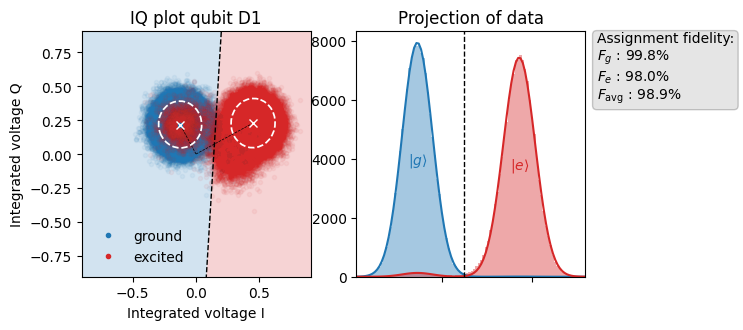

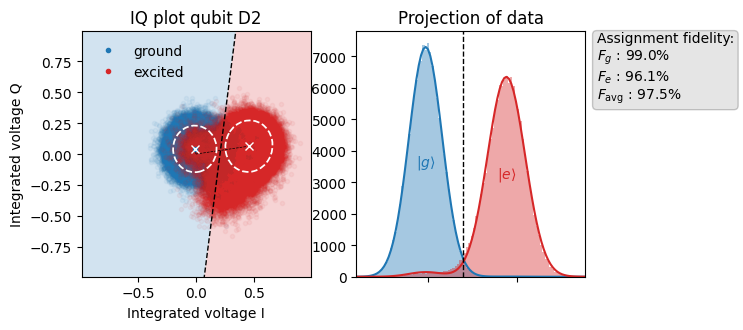

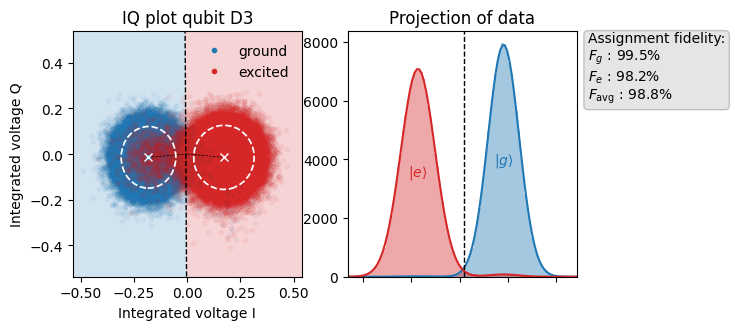

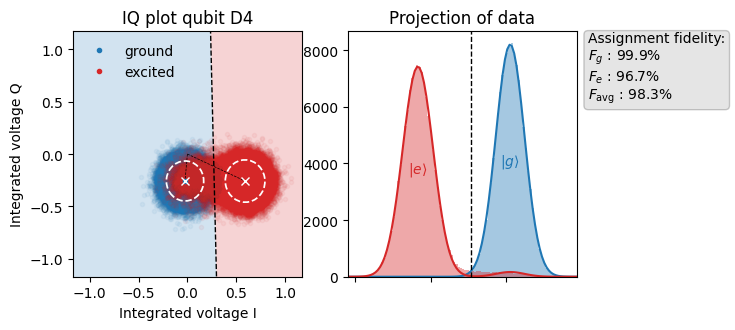

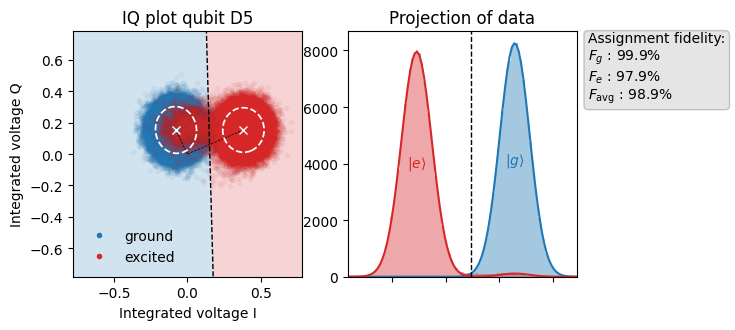

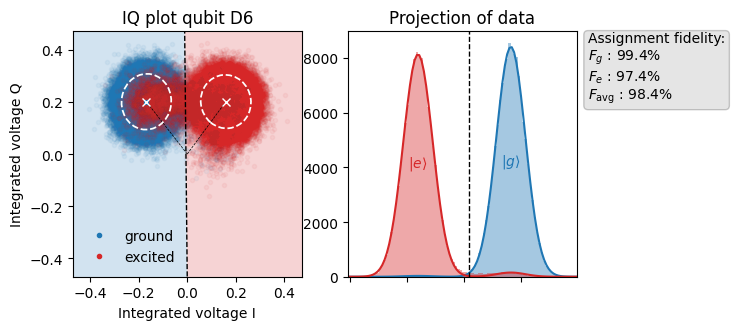

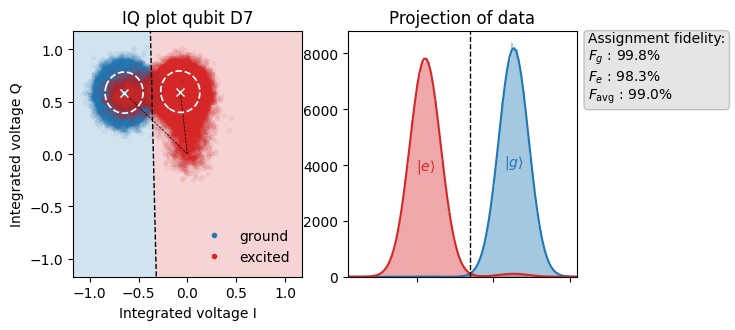

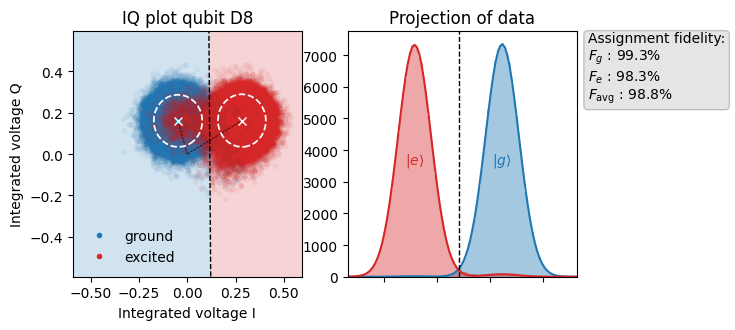

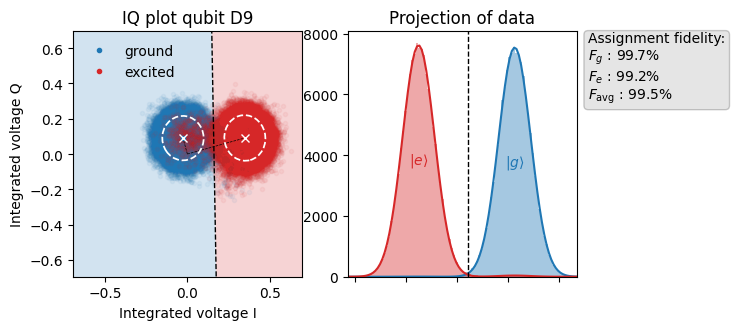

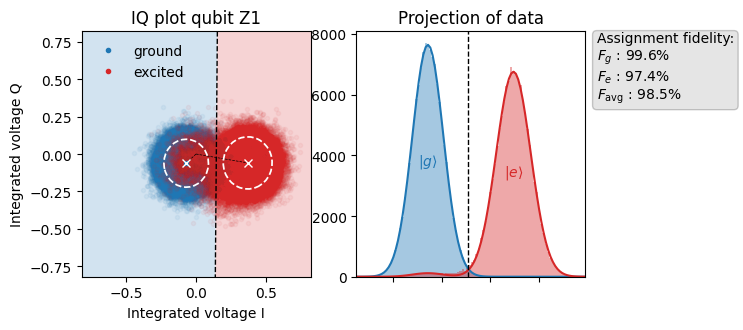

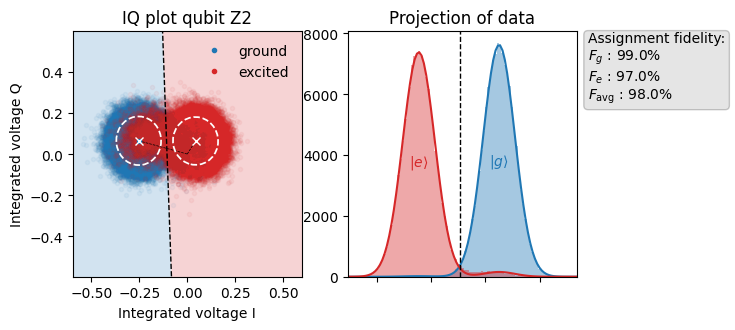

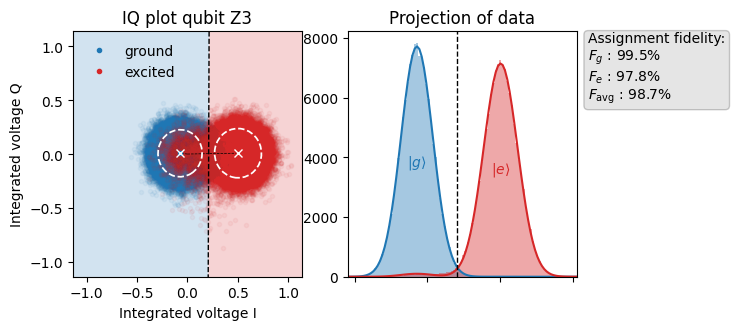

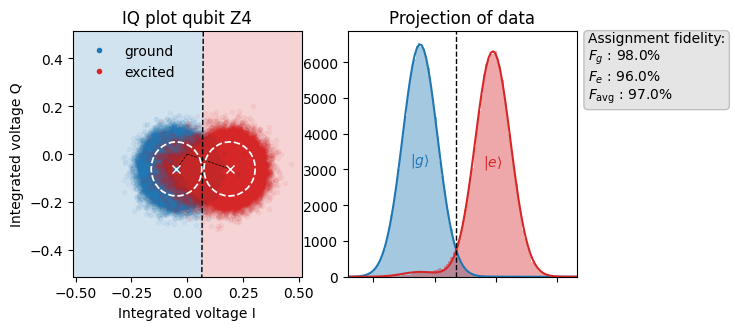

In [5]:
from Plot_functions import qubit_ssro_IQ_projection_plotfn
for q in Qubits:
    qubit_ssro_IQ_projection_plotfn(
        proc_data_dict = proc_data_dict,
        qubit = q)
    plt.show()

### Plot result of 3-state classifier

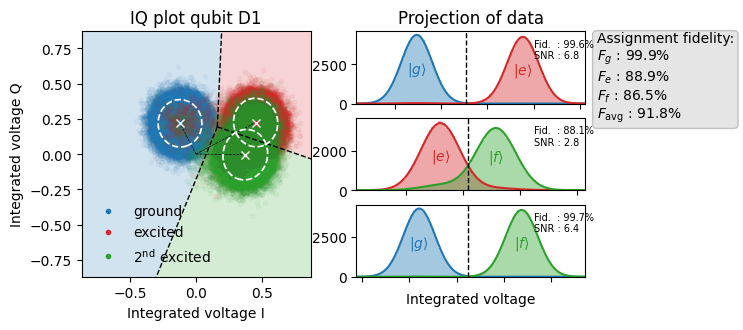

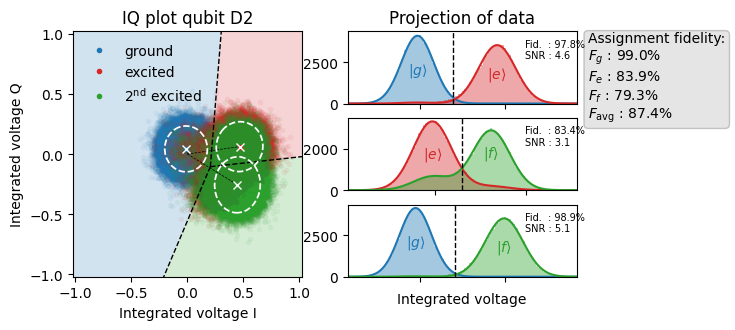

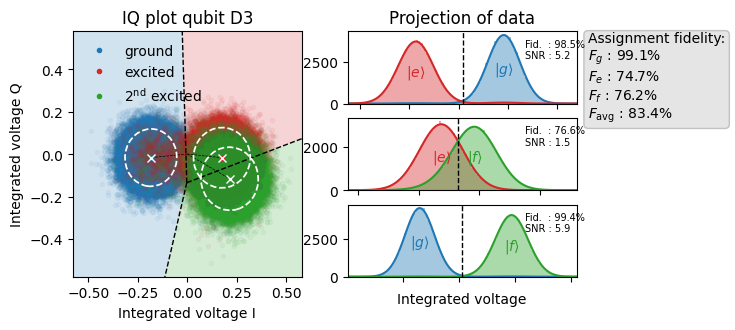

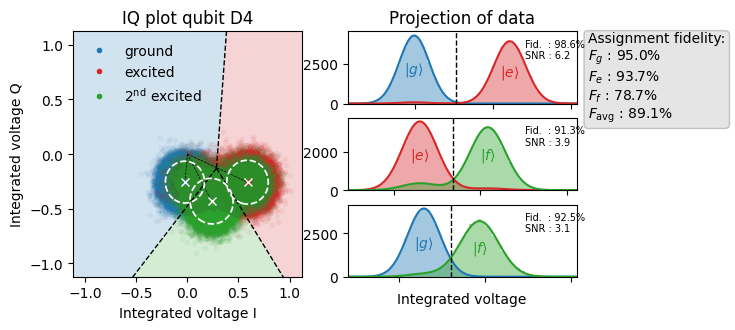

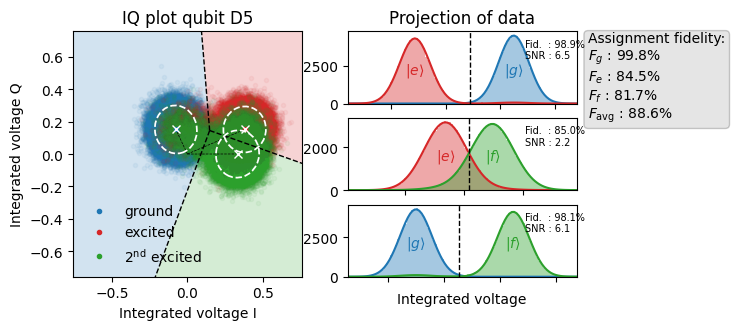

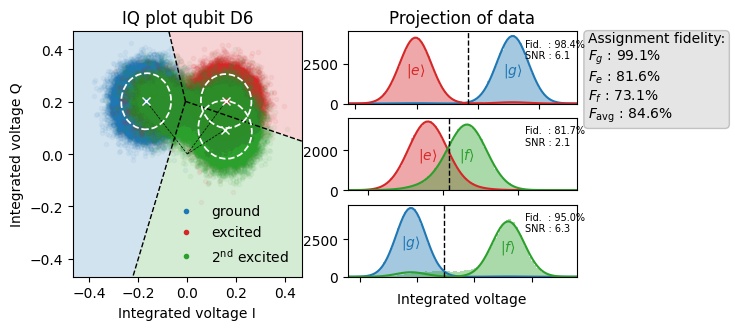

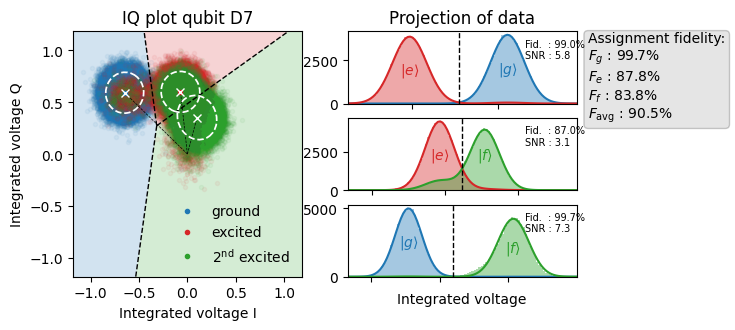

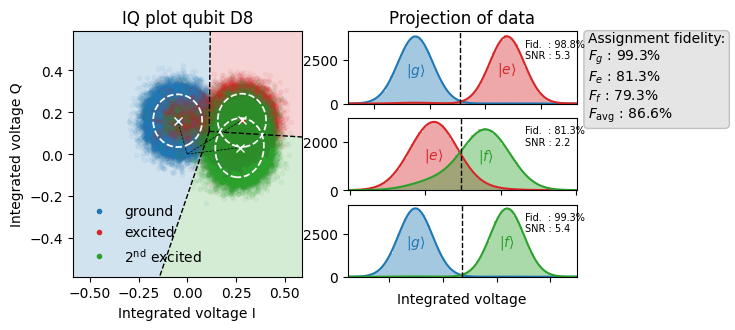

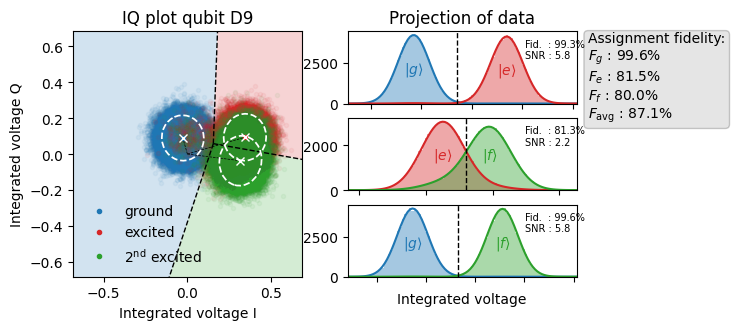

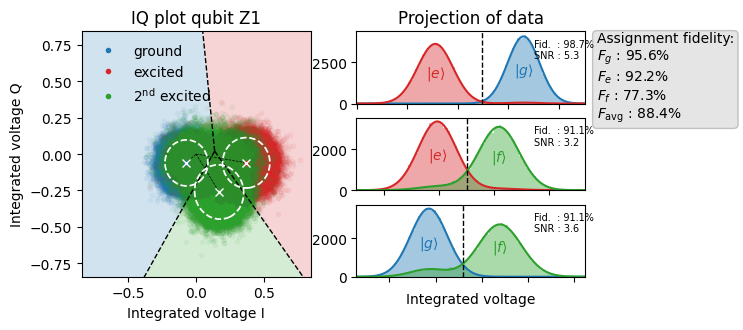

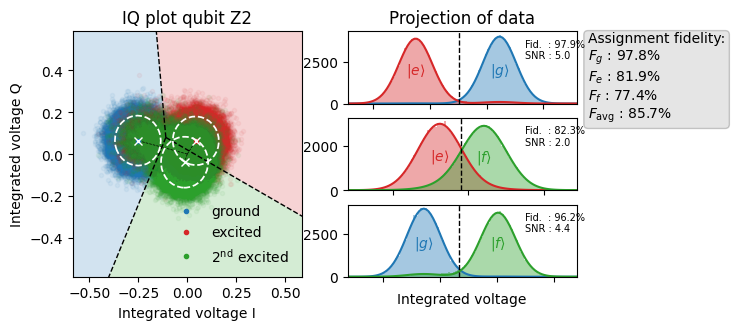

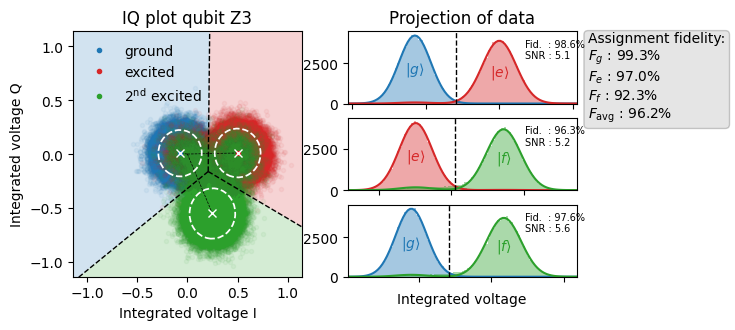

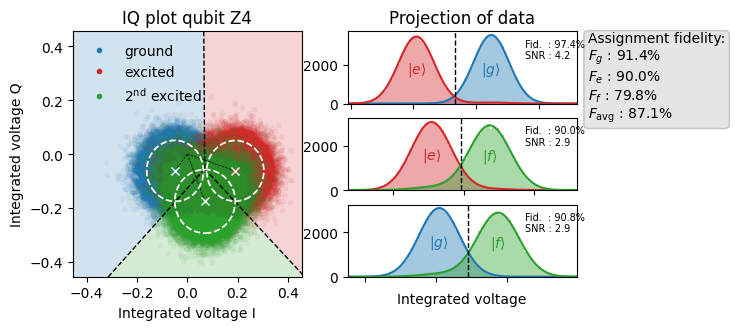

In [91]:
from Plot_functions import qutrit_ssro_IQ_projection_plotfn
for q in Qubits:
    qutrit_ssro_IQ_projection_plotfn(
        proc_data_dict = proc_data_dict,
        qubit = q)
    plt.show()

### Analyze experiment shots

Experiment shots will be stored in a three dictionaries.

 1. The digitized shots from qubit (2-state) readout:
    ```Python
    proc_data_dict['Shots_qubit'][k]['<qubit>']['<Rounds>_R']['round <r>'] = array[n_repetitions]
    ```
 2. The trigitized shots from qutrit (3-state) readout:
    ```Python
    proc_data_dict['Shots_qutrit'][k]['<qubit>']['<Rounds>_R']['round <r>'] = array[n_repetitions]
    ```
 3. The raw IQ voltages obtained from readout:
    ```Python
    proc_data_dict['Shots_exp'][k]['<qubit>']['<Rounds>_R']['round <r>'] = array[n_repetitions, 2]
    ```

where ```k``` stands for the experiment:
    
    Without LRU: k = 0

`<Rounds>` stands for the number of stabilizer measurements in the experiment,

`<r>` stands for the QEC round of the experiment. For data qubits the only relevant shots are the last round of the experiment `<Rounds>=<r>`. All other shots have no meaning.

Note: All shots are post-selected based on an initialization measurement that heralds successful initialization in the ground state.

In [6]:
##################################################################
# Sort and Analyze experiment shots, post-select
# on leakage and calculate defect rate
################################################################## 
# Sort experimental shots
# kernel 0 - Surface-13 without LRUs
# kernel 1 - Surface-13 with LRUs
shots_exp = { k:{} for k in range(n_kernels) }
Shots_qubit = { k:{} for k in range(n_kernels) }
Shots_qutrit = { k:{} for k in range(n_kernels) }
for k in range(n_kernels):
    shots_exp[k] = {q: {} for q in Qubits}
    Shots_qubit[k] = {q: {} for q in Qubits}
    Shots_qutrit[k] = {q: {} for q in Qubits}
for q in Qubits:
    _clf_qubit = proc_data_dict[q]['classifier_qubit']
    _clf_qutrit = proc_data_dict[q]['classifier_qutrit']
    for r_idx, n_rounds in enumerate(Rounds):
        for k in range(n_kernels):
            shots_exp[k][q][f'{n_rounds}_R'] = {}
            Shots_qubit[k][q][f'{n_rounds}_R'] = {}
            Shots_qutrit[k][q][f'{n_rounds}_R'] = {}
        # counter for number of shots in previous rounds
        _aux = int(n_kernels*np.sum(Rounds[:r_idx]))
        if heralded_init:
            _aux = int(n_kernels*(np.sum(Rounds[:r_idx])+len(Rounds[:r_idx])))
        for r in range(n_rounds):
            # Note we are using the rotated shots already
            for k in range(n_kernels):
                shots_exp[k][q][f'{n_rounds}_R'][f'round {r+1}'] = \
                    raw_shots[q][r+k*(n_rounds+heralded_init)+heralded_init+_aux::_cycle]    
            for k in range(n_kernels):       
                # Perform Qubit assignment
                Shots_qubit[k][q][f'{n_rounds}_R'][f'round {r+1}'] = \
                    _clf_qubit.predict(shots_exp[k][q][f'{n_rounds}_R'][f'round {r+1}'])
                # Perform Qutrit assignment
                Shots_qutrit[k][q][f'{n_rounds}_R'][f'round {r+1}'] = \
                    _clf_qutrit.predict(shots_exp[k][q][f'{n_rounds}_R'][f'round {r+1}'])
        # Sort heralding measurement shots
        if heralded_init:
            for k in range(n_kernels):
                shots_exp[k][q][f'{n_rounds}_R']['ps'] = \
                    raw_shots[q][k*(n_rounds+heralded_init)+_aux::_cycle]
                # Classify heralding shots (round 0 is defined for heralding measurement)
                Shots_qutrit[k][q][f'{n_rounds}_R']['round 0'] = \
                    _clf_qutrit.predict(shots_exp[k][q][f'{n_rounds}_R']['ps'])
                # Compute post-selection mask 
                # (used to signal heralding: 1-successful init. ; np.nan-unsuccessfull init.)
                Shots_qutrit[k][q][f'{n_rounds}_R']['ps'] = \
                    np.array([1 if s == 0 else np.nan for s in Shots_qutrit[k][q][f'{n_rounds}_R']['round 0']])
##################################################################
##################################################################
# Post-selection on heralding measurement
##################################################################
if heralded_init:
    for R in Rounds:
        _n_shots = len(Shots_qutrit[0][q][f'{R}_R']['ps'])
        _mask = { k : np.ones(_n_shots) for k in range(n_kernels) }
        for q in Qubits:
            for k in range(n_kernels):
                _mask[k] *= Shots_qutrit[k][q][f'{R}_R']['ps']
        for k in range(n_kernels):
            print(f'{R}_R Percentage of post-selected shots {k}: {np.nansum(_mask[k])/len(_mask[k])*100:.2f}%')
        for q in Qubits:
            for r in range(R):
                for k in range(n_kernels):
                    # Remove marked (unsuccessful initialization) shots in qubit shots
                    Shots_qubit[k][q][f'{R}_R'][f'round {r+1}'] = \
                        Shots_qubit[k][q][f'{R}_R'][f'round {r+1}'][~np.isnan(_mask[k])]
                    # Remove marked (unsuccessful initialization) shots in qutrit shots
                    Shots_qutrit[k][q][f'{R}_R'][f'round {r+1}'] = \
                        Shots_qutrit[k][q][f'{R}_R'][f'round {r+1}'][~np.isnan(_mask[k])]
###########################
## Leakage postselection 
###########################
# postselect leakage runs based on ancilla qubit msmt, all bad shots are not included 
Shots_qubit_ps = { k:{} for k in range(n_kernels) }
Shots_qubit_ps_all = { k:{} for k in range(n_kernels) }
Ps_fraction_L = { k : np.ones(Rounds[-1]) for k in range(n_kernels) }
Ps_fraction_L_D = { k : np.ones(Rounds[-1]) for k in range(n_kernels) }
_mask_l = { k : {} for k in range(n_kernels) }
_mask_ld = { k : {} for k in range(n_kernels) }
for k in range(n_kernels):
    Shots_qubit_ps[k] = {q: {} for q in Qubits}
    Shots_qubit_ps_all[k] = {q: {} for q in Qubits}
for q in Qubits:
    for k in range(n_kernels):
        Shots_qubit_ps[k][q] = {f'{R}_R': {} for R in Rounds}
        Shots_qubit_ps_all[k][q] = {f'{R}_R': {} for R in Rounds}
        for R in Rounds:
            _n_shots = len(Shots_qutrit[k][q][f'{R}_R'][f'round {1}'])
            _mask_l[k] = np.ones(_n_shots)
            for r in range(R):
                for qa in Qubits[-4:]:
                    _mask_l[k] *= np.array([1 if s != 2 else np.nan for s in Shots_qutrit[k][qa][f'{R}_R'][f'round {r+1}']])
                Ps_fraction_L[k][r] = np.nansum(_mask_l[k])/_n_shots
                Shots_qubit_ps[k][q][f'{R}_R'][f'round {r+1}'] = Shots_qutrit[k][q][f'{R}_R'][f'round {r+1}']*_mask_l[k]
# postselect leakage runs based on final data qubit msmt 
for q in Qubits[:-4]:
    for k in range(n_kernels):
        for R in Rounds:
            _n_shots_d = len(Shots_qubit_ps[k][q][f'{R}_R'][f'round {R}'])
            _mask_ld[k] = np.ones(_n_shots_d)
            for qa in Qubits[:-4]:
                _mask_ld[k] *= np.array([1 if s != 2 else np.nan for s in Shots_qubit_ps[k][qa][f'{R}_R'][f'round {R}']])
            Ps_fraction_L_D[k] = np.nansum(_mask_ld[k])/_n_shots_d
            Shots_qubit_ps_all[k][q][f'{R}_R'][f'round {R}'] = Shots_qubit_ps[k][q][f'{R}_R'][f'round {R}']*_mask_ld[k]
for q in Qubits[:-4]:
    for k in range(n_kernels):
        for R in Rounds:
            Shots_qubit_ps[k][q][f'{R}_R'][f'round {R}'] = Shots_qubit_ps_all[k][q][f'{R}_R'][f'round {R}']
# Save processed data
proc_data_dict['Shots_qubit'] = Shots_qubit
proc_data_dict['Shots_qutrit'] = Shots_qutrit
proc_data_dict['Shots_exp'] = shots_exp
proc_data_dict['L_PS'] = Ps_fraction_L
proc_data_dict['L_PS_D'] = Ps_fraction_L_D
proc_data_dict['Shots_qubit_ps'] = Shots_qubit_ps
proc_data_dict['Shots_qubit_ps_all'] = Shots_qubit_ps_all

1_R Percentage of post-selected shots 0: 68.60%
1_R Percentage of post-selected shots 1: 72.83%
2_R Percentage of post-selected shots 0: 73.28%
2_R Percentage of post-selected shots 1: 70.16%
4_R Percentage of post-selected shots 0: 70.04%
4_R Percentage of post-selected shots 1: 69.75%
8_R Percentage of post-selected shots 0: 69.75%
8_R Percentage of post-selected shots 1: 69.89%
16_R Percentage of post-selected shots 0: 69.95%
16_R Percentage of post-selected shots 1: 70.15%


### Calculate leakage

For each qubit we calculate the qutrit level population (correcting for readout assignment error) and store it
in the dictionary `Population`.
For data qubits (which are only readout in the final round of the experiment), the format of the dictionary follows:

```Python
proc_data_dict['Population'][k]['<data_qubit>']['<Rounds>_R'] = [p0, p1, p2]
```

while for ancilla qubits (which are readout at every QEC round `r`):

```Python
proc_data_dict['Population'][k]['<ancilla_qubit>']['<Rounds>_R']['round <r>'] = [p0, p1, p2]
```

where ```k``` stands for the experiment:
    
    Without LRU: k = 0

`<Rounds>` stands for the number of stabilizer measurements in the experiment,

and `[p0, p1, p2]` is the population vector in the order $|0\rangle$, $|1\rangle$ and $|2\rangle$.

Note: Also added `proc_data_dict['Population_f']` which follows the same format but only stores leakage population.

In [7]:
##################################################################
# Calculate leakage population as function of rounds
##################################################################
Population = { k: {q:{} for q in Qubits}\
               for k in range(n_kernels) }
Population_f = { k: {q:{} for q in Qubits}\
               for k in range(n_kernels) }
def _get_pop_vector(Shots):
    p0 = np.mean(Shots==0)
    p1 = np.mean(Shots==1)
    p2 = np.mean(Shots==2)
    return np.array([p0, p1, p2])
for q in Qubits:
    M_inv = np.linalg.inv(proc_data_dict[q]['Assignment_matrix_qutrit'])
    if 'Z' in q:
        # For ancilla qubits we can calculate  
        # leakage in every measurement round.
        for n_rounds in Rounds:
            for k in range(n_kernels):
                Population[k][q][f'{n_rounds}_R'] = {}
            for r in range(n_rounds):
                for k in range(n_kernels):
                    _pop_vec = _get_pop_vector(Shots_qutrit[k][q][f'{n_rounds}_R'][f'round {r+1}'])
                    Population[k][q][f'{n_rounds}_R'][f'round {r+1}'] = np.dot(_pop_vec, M_inv)
        for k in range(n_kernels):
            Population_f[k][q] = np.array([Population[k][q][f'{Rounds[-1]}_R'][key][2] for key in \
                                           Population[k][q][f'{Rounds[-1]}_R'].keys()])
    else:
        # For data qubits we can only calculate  
        # leakage in the last measurement round.
        for n_rounds in Rounds:
            for k in range(n_kernels):
                _pop_vec = _get_pop_vector(Shots_qutrit[k][q][f'{n_rounds}_R'][f'round {n_rounds}'])
                Population[k][q][f'{n_rounds}_R'] = np.dot(_pop_vec, M_inv)
        for k in range(n_kernels):
            Population_f[k][q] = np.array([Population[k][q][key][2] for key in Population[k][q].keys()])
proc_data_dict['Population'] = Population
proc_data_dict['Population_f'] = Population_f

### Compute defects

Defects data will be stored in dictionary as follows:

```Python
Defects['<ancila_qubit>'][k]['<Rounds>_R'] = np.array[repetitions, rounds]

```

and defect rate data will be stored in dictionary as follows:

```Python
Defect_rate['<ancila_qubit>'][k]['<Rounds>_R'] = np.array[rounds]

```
where ```k``` stands for the experiment:
    
    Without LRU: k = 0

`<Rounds>` stands for the number of stabilizer measurements in the experiment,

`repetitions` repetitions is the number of times we repeated the particular experiment (after post-selection),

and `rounds` stands for the QEC round of the experiment (in the range `[0, <Rounds>]` including defects computed from the final data qubit measurement).

Note: Defects data is represented in +1/-1 where -1 corresponds to a defect. For all stabilizers we track the initial Pauli frame with parity +1.

In [8]:
##################################################################
# Calculate defects
##################################################################
# Calculate defects for each stabilizer (ancilla qubit)
_Ancilla_qubits = [q for q in Qubits if 'Z' in q]
Defects = { q : { k:{} for k in range(n_kernels) } for q in _Ancilla_qubits }
Defects_f = { q : { k:{} for k in range(n_kernels) } for q in _Ancilla_qubits }
Defects_MV = { q : { k:{} for k in range(n_kernels) } for q in _Ancilla_qubits }
Defects_MV_f = { q : { k:{} for k in range(n_kernels) } for q in _Ancilla_qubits }
Defect_rate = { q : { k:{} for k in range(n_kernels) } for q in _Ancilla_qubits }
Defect_rate_f = { q : { k:{} for k in range(n_kernels) } for q in _Ancilla_qubits }
for q in _Ancilla_qubits:
    for n_rounds in Rounds:
        for k in range(n_kernels):
            # Data qubits measured by each stabilizer
            # (will be used to compute measured data-qubit parity)
            if q == 'Z1':
                stab_data_qubits = ['D1', 'D2', 'D4', 'D5']
            elif q == 'Z2':
                stab_data_qubits = ['D3', 'D6']
            elif q == 'Z3':
                stab_data_qubits = ['D4', 'D7']
            elif q == 'Z4':
                stab_data_qubits = ['D5', 'D6', 'D8', 'D9']
            # Sort final data qubit measurement shots
            Data_shots = [Shots_qubit[k][_dq][f'{n_rounds}_R'][f'round {n_rounds}'] \
                          for _dq in stab_data_qubits]
            
            # Sort final data qubit measurement shots
            Data_shots_ps = [Shots_qubit_ps[k][_dq][f'{n_rounds}_R'][f'round {n_rounds}'] \
                          for _dq in stab_data_qubits]
            # Compute defects
            Defects[q][k][f'{n_rounds}_R'] = \
                _calculate_defects(Shots_qubit[k][q][f'{n_rounds}_R'],
                                   n_rounds, Data_qubit_meas=Data_shots)
            # Compute defects while signaling leakage on ancilla qubits
#             Defects_f[q][k][f'{n_rounds}_R'] = \
#                 _calculate_defects(Shots_qutrit[k][q][f'{n_rounds}_R'],
#                                    n_rounds, Data_qubit_meas=Data_shots_ps)
            Defects_f[q][k][f'{n_rounds}_R'] = \
                _calculate_defects(Shots_qubit_ps[k][q][f'{n_rounds}_R'],
                                   n_rounds, Data_qubit_meas=Data_shots_ps)
            # Compute defects for Majority voting decoder
            # To disregard ancilla qubit measurements we'll create a dummy array
            # of ancilla qubit shots that are all zero
            _dummy_shots = { key: np.zeros(arr.shape) \
                             for key, arr in Shots_qubit[k][q][f'{n_rounds}_R'].items() }
            Defects_MV[q][k][f'{n_rounds}_R'] = \
                _calculate_defects(_dummy_shots, n_rounds, Data_qubit_meas=Data_shots)
            # With leakage post-selection
            _dummy_shots_f = { key: (arr==2)*2 \
                               for key, arr in Shots_qutrit[k][q][f'{n_rounds}_R'].items() }
            Defects_MV_f[q][k][f'{n_rounds}_R'] = \
                _calculate_defects(_dummy_shots_f, n_rounds, Data_qubit_meas=Data_shots)
            # Compute defect probability
            Defect_rate[q][k][f'{n_rounds}_R'] = np.mean((1-Defects[q][k][f'{n_rounds}_R'])/2, axis=0)
            # Compute defect probability (post-selecting on ancilla leakage)
            Defect_rate_f[q][k][f'{n_rounds}_R'] = np.nanmean((1-Defects_f[q][k][f'{n_rounds}_R'])/2,
                                                              axis=0)

### Plot defect rates and leakage for stabilzer

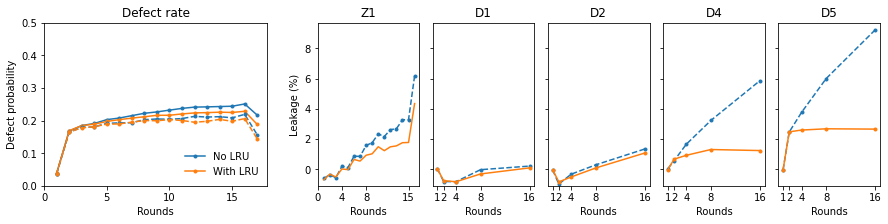

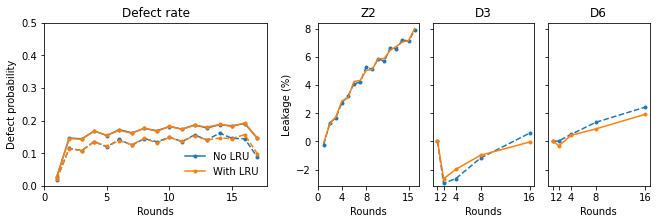

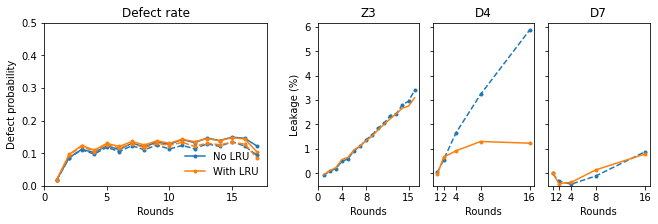

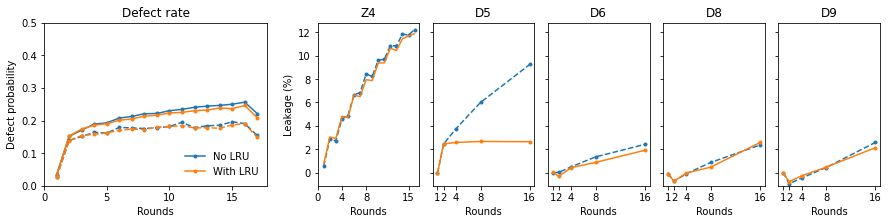

In [9]:
import Plot_functions as plt_func
reload(plt_func)

from Plot_functions import _plot_defect_rate_and_leakage


for stab in ['Z1', 'Z2', 'Z3', 'Z4']:
    _plot_defect_rate_and_leakage(
        stab,
        Rounds,
        Defect_rate,
        Population_f,
        Defect_rate_f = Defect_rate_f, # plot ps on ancilla leakage 
        )

## Decode [LOG OP & +LUT & +MV] 

Logical operator (X1...X9)     :	 0.898840
Logical operator (X1...X9) PS    :	 0.920857
Logical operator (X1...X9) QED   :	 1.000000
Logical operator (X1...X9) QEC-LUT :	 0.990391
Logical operator (X1...X9) QEC-LUTD :	 0.998699
Logical operator (X1...X9) QEC-L ps :	 0.993487
Logical operator (X1...X9)     :	 -0.270385
Logical operator (X1...X9) PS    :	 -0.263174
Logical operator (X1...X9) QED   :	 0.999168
Logical operator (X1...X9) QEC-LUT :	 -0.807277
Logical operator (X1...X9) QEC-LUTD :	 -0.867721
Logical operator (X1...X9) QEC-L ps :	 -0.821608
Logical operator (X1...X9)     :	 -0.078476
Logical operator (X1...X9) PS    :	 -0.084718
Logical operator (X1...X9) QED   :	 0.998449
Logical operator (X1...X9) QEC-LUT :	 -0.627953
Logical operator (X1...X9) QEC-LUTD :	 -0.657971
Logical operator (X1...X9) QEC-L ps :	 -0.661885
Logical operator (X1...X9)     :	 -0.003605
Logical operator (X1...X9) PS    :	 -0.005468
Logical operator (X1...X9) QED   :	 0.997119
Logical operator (X1...X9) 

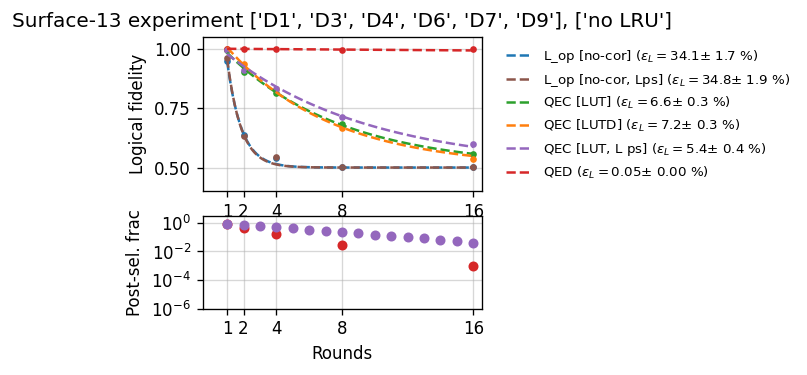

Logical operator (X1...X9)     :	 0.903783
Logical operator (X1...X9) PS    :	 0.925954
Logical operator (X1...X9) QED   :	 1.000000
Logical operator (X1...X9) QEC-LUT :	 0.990726
Logical operator (X1...X9) QEC-LUTD :	 0.998590
Logical operator (X1...X9) QEC-L ps :	 0.993579
Logical operator (X1...X9)     :	 -0.258782
Logical operator (X1...X9) PS    :	 -0.239993
Logical operator (X1...X9) QED   :	 0.999149
Logical operator (X1...X9) QEC-LUT :	 -0.809214
Logical operator (X1...X9) QEC-LUTD :	 -0.866702
Logical operator (X1...X9) QEC-L ps :	 -0.819582
Logical operator (X1...X9)     :	 -0.065114
Logical operator (X1...X9) PS    :	 -0.056604
Logical operator (X1...X9) QED   :	 0.998218
Logical operator (X1...X9) QEC-LUT :	 -0.624015
Logical operator (X1...X9) QEC-LUTD :	 -0.651468
Logical operator (X1...X9) QEC-L ps :	 -0.638772
Logical operator (X1...X9)     :	 -0.006600
Logical operator (X1...X9) PS    :	 -0.012979
Logical operator (X1...X9) QED   :	 0.997815
Logical operator (X1...X9) 

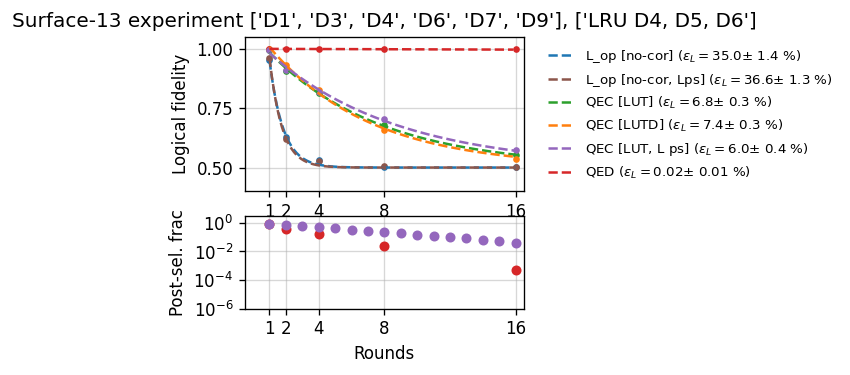

In [10]:
# extract useful quantities
LOG_OP =  {} 
LOG_OP_QEC = {}
LOG_OP_QED = {}
PS_FRACTION = {} 
LOG_OP_QEC_D = {}
LOG_OP_QEC_ps = {}
defects = {} 
data_qubits = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']
ancilla_qubits = ['Z1', 'Z2', 'Z3', 'Z4']
keys = [['no LRU'], ['LRU D4, D5, D6']]
for anc in ancilla_qubits:
    defects[anc] = {}
    for state in states:
        defects[anc][f'{state}'] =  np.zeros(Rounds[-1])
# state = "[]"
for k in range(n_kernels):
    shots_per_exp = proc_data_dict['Shots_qubit'][k]
    Leakage_ps = proc_data_dict['L_PS'][k]
    Leakage_ps[-1]= Leakage_ps[-1]*Ps_fraction_L_D[k]
    Rounds = [1,2,4,8,16]
    # quantities of interest
    PS_fraction = []
    L = [] 
    L_QEC= []
    L_QEC_D = []
    L_QED = []
    L_QEC_ps = []
    L_ps = []
    Shots_for_QED = deepcopy(proc_data_dict['Shots_qubit'][k])
    for qubit in data_qubits+ancilla_qubits: 
        for R in Rounds:
            for r in range(1,R+1):
                Shots_for_QED[qubit][f'{R}_R'][f'round {r}'] = (1-2*Shots_for_QED[qubit][f'{R}_R'][f'round {r}'])
    shots_per_exp_ps = proc_data_dict['Shots_qubit_ps'][k]
    for r in Rounds:
        S_values = {anc : (1-Defects[anc][k][f'{r}_R'])/2 for anc in ancilla_qubits }
        S_values_MV = {anc : (1-Defects_MV[anc][k][f'{r}_R'])/2 for anc in ancilla_qubits }
        S_values_ps = {anc : (1-Defects_f[anc][k][f'{r}_R'][~np.isnan(Defects_f[anc][k][f'{r}_R']).any(axis=1)])/2 for anc in ancilla_qubits }
        pauli_frame = _pauli_frame_update(S_values,r,ancilla_qubits)
        pauli_frame_MV = _pauli_frame_update(S_values_MV,r,ancilla_qubits)
        pauli_frame_ps = _pauli_frame_update(S_values_ps,r,ancilla_qubits)
        Log_op = _compute_logical_operator_shots(data_qubits ,shots_per_exp, r)
        Log_op_ps = _compute_logical_operator_shots(data_qubits ,shots_per_exp_ps, r)
        L_QED.append(np.abs(np.mean(_QED_ps(r, Shots_for_QED,ancilla_qubits, data_qubits)[0]))) # PS for QED
        PS_fraction.append(_QED_ps(r, Shots_for_QED, ancilla_qubits, data_qubits)[1]) # PS for QED 
        Log_op_QEC = np.mean(Log_op*pauli_frame)
        Log_op_QEC_D = np.mean(Log_op*pauli_frame_MV)
        Log_op_QEC_ps = np.mean(Log_op_ps*pauli_frame_ps)
        L.append(np.mean(Log_op))
        L_ps.append(np.mean(Log_op_ps))
        L_QEC.append(Log_op_QEC)
        L_QEC_D.append(Log_op_QEC_D)
        L_QEC_ps.append(Log_op_QEC_ps)
        print('Logical operator (X1...X9)     :\t {:f}'.format(np.mean(Log_op)))
        print('Logical operator (X1...X9) PS    :\t {:f}'.format(np.mean(Log_op_ps)))
        print('Logical operator (X1...X9) QED   :\t {:f}'.format(np.mean(L_QED)))
        print('Logical operator (X1...X9) QEC-LUT :\t {:f}'.format(Log_op_QEC))
        print('Logical operator (X1...X9) QEC-LUTD :\t {:f}'.format(Log_op_QEC_D))
        print('Logical operator (X1...X9) QEC-L ps :\t {:f}'.format(Log_op_QEC_ps))
    ## calculate LOG fideilties 
    L = (np.abs(L)+1)/2
    L_ps = (np.abs(L_ps)+1)/2
    L_QEC = (np.abs(L_QEC)+1)/2
    L_QEC_D = (np.abs(L_QEC_D)+1)/2
    L_QEC_ps = (np.abs(L_QEC_ps)+1)/2
    L_QED = (np.abs(L_QED)+1)/2
    # plot and anylsis logical error rate
    ## fitting model
    from lmfit import Model
    def func(qec_round, err_rate=0.1, round_offset = 0):
        return 0.5 * (1 + (1 - 2*err_rate)**(qec_round-round_offset))
    log_decay_model = Model(func)
    # fitting 
    fit_L = log_decay_model.fit(L, qec_round = Rounds)
    fit_L_ps = log_decay_model.fit(L_ps, qec_round = Rounds)
    fit_L_QEC = log_decay_model.fit(L_QEC, qec_round = Rounds)
    fit_L_QEC_D = log_decay_model.fit(L_QEC_D, qec_round = Rounds)
    fit_L_QEC_ps = log_decay_model.fit(L_QEC_ps, qec_round = Rounds)
    fit_L_QED = log_decay_model.fit(L_QED[:-1], qec_round = Rounds[:-1])
    fig, ax = plt.subplots(figsize=(3,3), dpi =120, nrows=2, ncols=1, gridspec_kw={'height_ratios': [2,1.2]})
    ax[0].plot(np.array(Rounds),L,'C0.')
    ax[0].plot(np.array(Rounds),L_ps,'C5.')
    ax[0].plot(np.array(Rounds),L_QEC,'C2.')
    ax[0].plot(np.array(Rounds),L_QEC_D,'C1.')
    ax[0].plot(np.array(Rounds),L_QED,'C3.')
    ax[0].plot(np.array(Rounds),L_QEC_ps,'C4.')
    cycles_cont = np.linspace(1, Rounds[-1], 101)
    L_error = fit_L.params["err_rate"].value
    L_stdr = fit_L.params["err_rate"].stderr
    L_error_ps = fit_L_ps.params["err_rate"].value
    L_stdr_ps = fit_L_ps.params["err_rate"].stderr
    QEC_error = fit_L_QEC.params["err_rate"].value
    QEC_stdr = fit_L_QEC.params["err_rate"].stderr
    QEC_error_D = fit_L_QEC_D.params["err_rate"].value
    QEC_stdr_D = fit_L_QEC_D.params["err_rate"].stderr
    QEC_error_ps = fit_L_QEC_ps.params["err_rate"].value
    QEC_stdr_ps = fit_L_QEC_ps.params["err_rate"].stderr
    QED_error_ps = fit_L_QED.params["err_rate"].value
    QED_stdr_ps = fit_L_QED.params["err_rate"].stderr
    ax[0].plot(cycles_cont, log_decay_model.eval(fit_L.params, qec_round=cycles_cont), 
            'C0--',label=f'L_op [no-cor] ($\epsilon_L={L_error*100:.1f}$' + f'$\pm$ {L_stdr*100:.1f} %)')
    ax[0].plot(cycles_cont, log_decay_model.eval(fit_L_ps.params, qec_round=cycles_cont), 
            'C5--',label=f'L_op [no-cor, Lps] ($\epsilon_L={L_error_ps*100:.1f}$' + f'$\pm$ {L_stdr_ps*100:.1f} %)')
    ax[0].plot(cycles_cont, log_decay_model.eval(fit_L_QEC.params, qec_round=cycles_cont),
            'C2--',label=f'QEC [LUT] ($\epsilon_L={QEC_error*100:.1f}$' + f'$\pm$ {QEC_stdr*100:.1f} %)')
    ax[0].plot(cycles_cont, log_decay_model.eval(fit_L_QEC_D.params, qec_round=cycles_cont),
            'C1--',label=f'QEC [LUTD] ($\epsilon_L={QEC_error_D*100:.1f}$' + f'$\pm$ {QEC_stdr_D*100:.1f} %)')
    ax[0].plot(cycles_cont, log_decay_model.eval(fit_L_QEC_ps.params, qec_round=cycles_cont),
            'C4--',label=f'QEC [LUT, L ps] ($\epsilon_L={QEC_error_ps*100:.1f}$' + f'$\pm$ {QEC_stdr_ps*100:.1f} %)')
    ax[0].plot(cycles_cont[:-1], log_decay_model.eval(fit_L_QED.params, qec_round=cycles_cont[:-1]),
            'C3--',label=f'QED ($\epsilon_L={QED_error_ps*100:.2f}$' + f'$\pm$ {QED_stdr_ps*100:.2f} %)')
    ax[0].set_xticks(Rounds)
    ax[0].set_yticks([1,0.75,0.5])
    ax[0].set_xlabel('Rounds')
    ax[0].set_ylabel('Logical fidelity')
    ax[0].set_ylim(bottom=0.4)
    ax[0].set_ylim(top=1.05)
    ax[0].set_xlim(xmin = -0.5, xmax=Rounds[-1]+0.5)
    ax[0].grid(alpha=0.5)
    ax[0].set_title(f'Surface-13 experiment {state}, {keys[k]}')
    ax[0].legend(loc='center right', bbox_to_anchor=(2.15, 0.5),fontsize=8,frameon=False )

    ax[1].grid(alpha=0.5)
    ax[1].plot(Rounds, PS_fraction, 'C3o', markersize=5)
    ax[1].plot(range(1,Rounds[-1]+1), Leakage_ps, 'C4o', markersize=5)
    ax[1].set_yscale('log')
    ax[1].set_yticks([1e0, 1e-2, 1e-4, 1e-6])
    ax[1].set_ylim(top=3, bottom=1e-6)
    ax[1].set_ylabel('Post-sel. frac')
    ax[1].set_xlabel('Rounds')
    ax[1].set_xticks(Rounds)

    ax[1].set_xlim(xmin = -0.5, xmax=Rounds[-1]+0.5)
    fig.patch.set_visible(False)
#     fn = join(figdir, f"logical_performance_{state}_{k}.png")
#     fig.savefig(fn, dpi=300, bbox_inches='tight', format='png')
    plt.show()
    # save_values_of_interest 
    LOG_OP[f'{state}'] = L
    LOG_OP_QEC[f'{state}'] = L_QEC
    LOG_OP_QEC_D[f'{state}'] = L_QEC_D
    LOG_OP_QEC_ps[f'{state}'] = LOG_OP_QEC_ps
    LOG_OP_QED[f'{state}'] = L_QED
    PS_FRACTION[f'{state}'] = PS_fraction
    for anc in ancilla_qubits:
        defects[anc][f'{state}'] = np.mean((1-Defects[anc][0][f'{Rounds[-1]}_R'])/2,axis = 0)

# Full logical zero analysis

1_R Percentage of post-selected shots 0: 68.60%
1_R Percentage of post-selected shots 1: 72.83%
2_R Percentage of post-selected shots 0: 73.28%
2_R Percentage of post-selected shots 1: 70.16%
4_R Percentage of post-selected shots 0: 70.04%
4_R Percentage of post-selected shots 1: 69.75%
8_R Percentage of post-selected shots 0: 69.75%
8_R Percentage of post-selected shots 1: 69.89%
16_R Percentage of post-selected shots 0: 69.95%
16_R Percentage of post-selected shots 1: 70.15%
Logical operator (X1...X9)     :	 0.898840
Logical operator (X1...X9) PS    :	 0.920857
Logical operator (X1...X9) QED   :	 1.000000
Logical operator (X1...X9) QEC-LUT :	 0.990391
Logical operator (X1...X9) QEC-LUTD :	 0.998699
Logical operator (X1...X9) QEC-L ps :	 0.993487
Logical operator (X1...X9) QEC-LD ps :	 0.999571
Logical operator (X1...X9)     :	 -0.270385
Logical operator (X1...X9) PS    :	 -0.263174
Logical operator (X1...X9) QED   :	 0.999168
Logical operator (X1...X9) QEC-LUT :	 -0.807277
Logical op

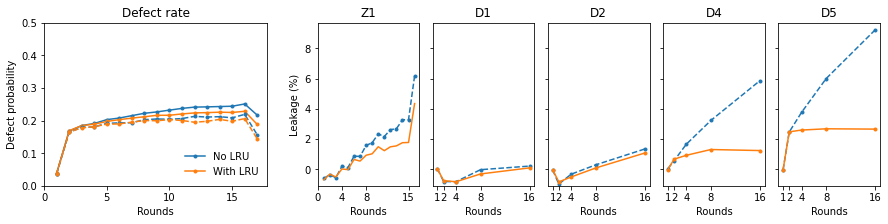

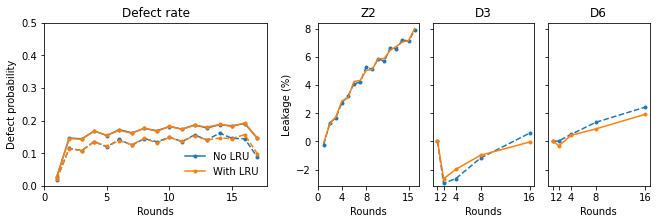

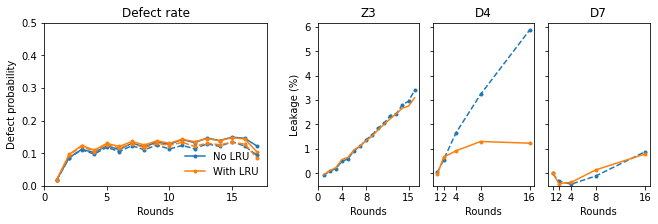

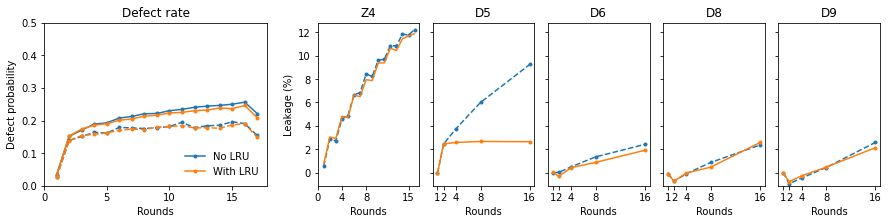

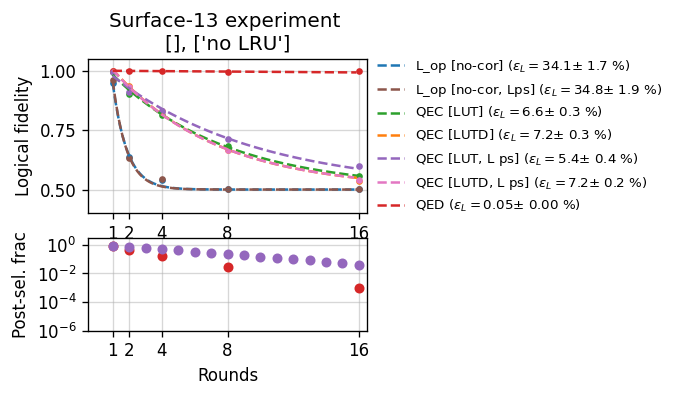

Logical operator (X1...X9)     :	 0.903783
Logical operator (X1...X9) PS    :	 0.925954
Logical operator (X1...X9) QED   :	 1.000000
Logical operator (X1...X9) QEC-LUT :	 0.990726
Logical operator (X1...X9) QEC-LUTD :	 0.998590
Logical operator (X1...X9) QEC-L ps :	 0.993579
Logical operator (X1...X9) QEC-LD ps :	 0.999267
Logical operator (X1...X9)     :	 -0.258782
Logical operator (X1...X9) PS    :	 -0.239993
Logical operator (X1...X9) QED   :	 0.999149
Logical operator (X1...X9) QEC-LUT :	 -0.809214
Logical operator (X1...X9) QEC-LUTD :	 -0.866702
Logical operator (X1...X9) QEC-L ps :	 -0.819582
Logical operator (X1...X9) QEC-LD ps :	 -0.861847
Logical operator (X1...X9)     :	 -0.065114
Logical operator (X1...X9) PS    :	 -0.056604
Logical operator (X1...X9) QED   :	 0.998218
Logical operator (X1...X9) QEC-LUT :	 -0.624015
Logical operator (X1...X9) QEC-LUTD :	 -0.651468
Logical operator (X1...X9) QEC-L ps :	 -0.638772
Logical operator (X1...X9) QEC-LD ps :	 -0.634480
Logical opera

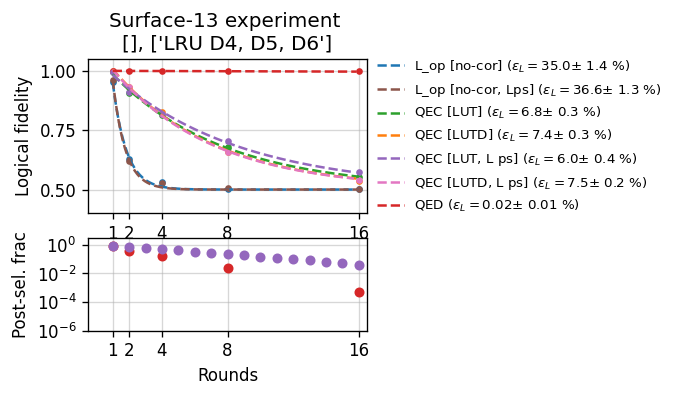

1_R Percentage of post-selected shots 0: 67.47%
1_R Percentage of post-selected shots 1: 71.52%
2_R Percentage of post-selected shots 0: 71.85%
2_R Percentage of post-selected shots 1: 70.53%
4_R Percentage of post-selected shots 0: 70.35%
4_R Percentage of post-selected shots 1: 70.17%
8_R Percentage of post-selected shots 0: 70.36%
8_R Percentage of post-selected shots 1: 70.20%
16_R Percentage of post-selected shots 0: 70.01%
16_R Percentage of post-selected shots 1: 70.05%
Logical operator (X1...X9)     :	 0.669240
Logical operator (X1...X9) PS    :	 0.679773
Logical operator (X1...X9) QED   :	 1.000000
Logical operator (X1...X9) QEC-LUT :	 0.977108
Logical operator (X1...X9) QEC-LUTD :	 0.991774
Logical operator (X1...X9) QEC-L ps :	 0.982243
Logical operator (X1...X9) QEC-LD ps :	 0.993844
Logical operator (X1...X9)     :	 -0.282332
Logical operator (X1...X9) PS    :	 -0.288504
Logical operator (X1...X9) QED   :	 0.999334
Logical operator (X1...X9) QEC-LUT :	 -0.820076
Logical op

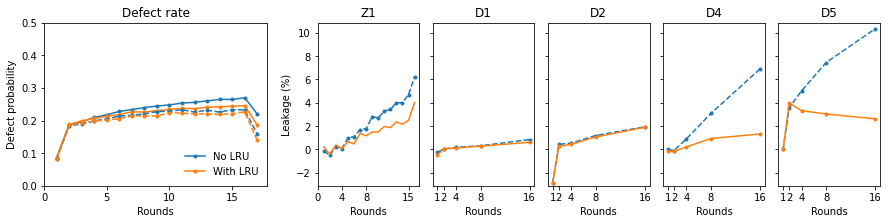

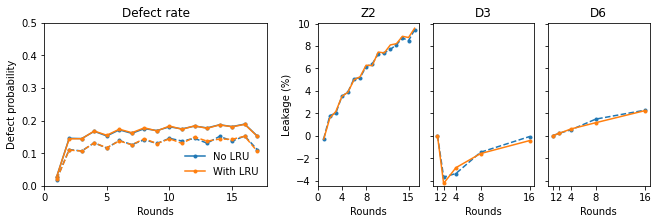

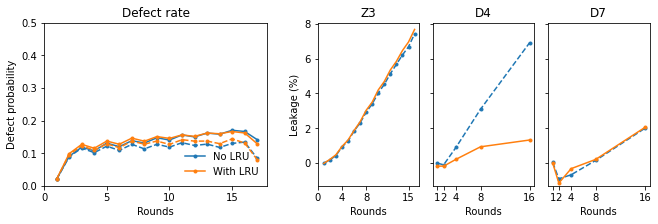

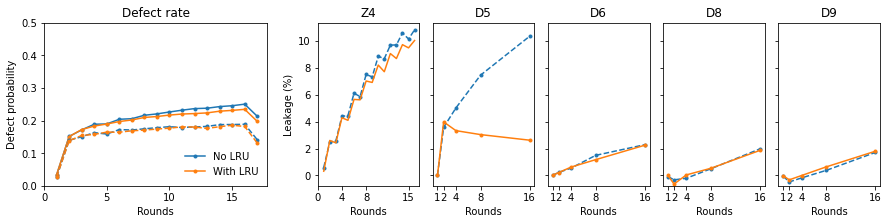

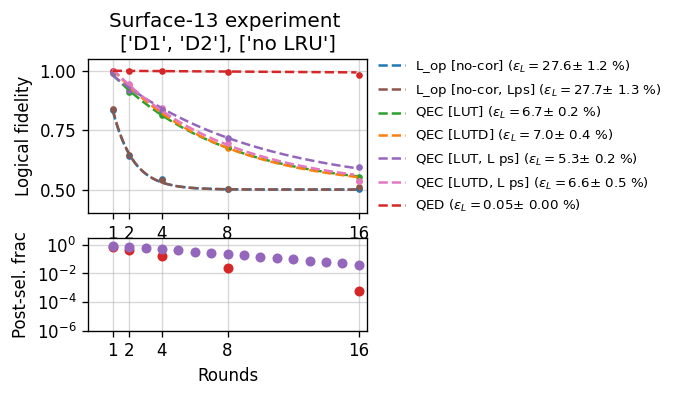

Logical operator (X1...X9)     :	 0.673803
Logical operator (X1...X9) PS    :	 0.680657
Logical operator (X1...X9) QED   :	 0.999972
Logical operator (X1...X9) QEC-LUT :	 0.977635
Logical operator (X1...X9) QEC-LUTD :	 0.992157
Logical operator (X1...X9) QEC-L ps :	 0.982063
Logical operator (X1...X9) QEC-LD ps :	 0.993905
Logical operator (X1...X9)     :	 -0.272733
Logical operator (X1...X9) PS    :	 -0.279471
Logical operator (X1...X9) QED   :	 0.999186
Logical operator (X1...X9) QEC-LUT :	 -0.819887
Logical operator (X1...X9) QEC-LUTD :	 -0.873596
Logical operator (X1...X9) QEC-L ps :	 -0.840045
Logical operator (X1...X9) QEC-LD ps :	 -0.882762
Logical operator (X1...X9)     :	 -0.075514
Logical operator (X1...X9) PS    :	 -0.086143
Logical operator (X1...X9) QED   :	 0.998452
Logical operator (X1...X9) QEC-LUT :	 -0.629692
Logical operator (X1...X9) QEC-LUTD :	 -0.666352
Logical operator (X1...X9) QEC-L ps :	 -0.671651
Logical operator (X1...X9) QEC-LD ps :	 -0.688601
Logical opera

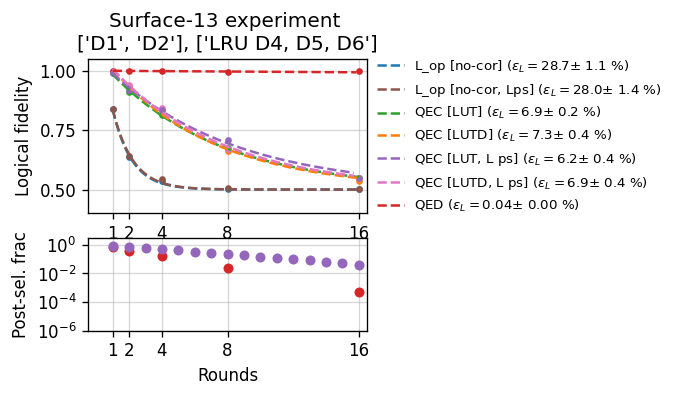

1_R Percentage of post-selected shots 0: 67.03%
1_R Percentage of post-selected shots 1: 70.12%
2_R Percentage of post-selected shots 0: 70.52%
2_R Percentage of post-selected shots 1: 70.40%
4_R Percentage of post-selected shots 0: 70.42%
4_R Percentage of post-selected shots 1: 70.08%
8_R Percentage of post-selected shots 0: 70.24%
8_R Percentage of post-selected shots 1: 69.99%
16_R Percentage of post-selected shots 0: 70.10%
16_R Percentage of post-selected shots 1: 70.14%
Logical operator (X1...X9)     :	 0.781559
Logical operator (X1...X9) PS    :	 0.796244
Logical operator (X1...X9) QED   :	 1.000000
Logical operator (X1...X9) QEC-LUT :	 0.980933
Logical operator (X1...X9) QEC-LUTD :	 0.994251
Logical operator (X1...X9) QEC-L ps :	 0.986018
Logical operator (X1...X9) QEC-LD ps :	 0.995777
Logical operator (X1...X9)     :	 -0.282060
Logical operator (X1...X9) PS    :	 -0.294622
Logical operator (X1...X9) QED   :	 0.999437
Logical operator (X1...X9) QEC-LUT :	 -0.822994
Logical op

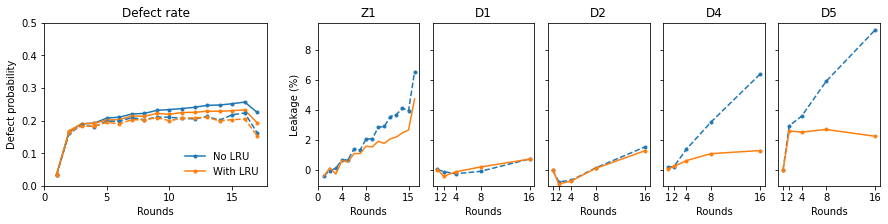

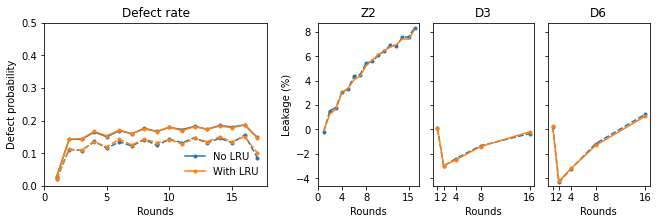

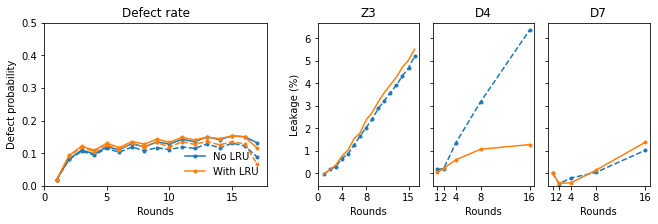

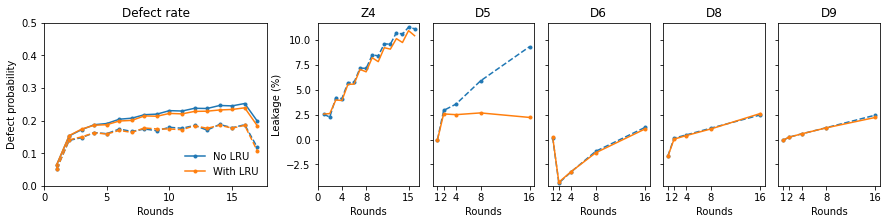

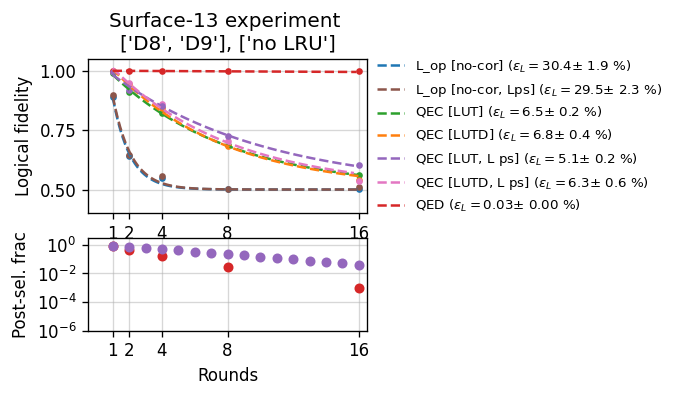

Logical operator (X1...X9)     :	 0.783427
Logical operator (X1...X9) PS    :	 0.799844
Logical operator (X1...X9) QED   :	 0.999973
Logical operator (X1...X9) QEC-LUT :	 0.980755
Logical operator (X1...X9) QEC-LUTD :	 0.994186
Logical operator (X1...X9) QEC-L ps :	 0.985624
Logical operator (X1...X9) QEC-LD ps :	 0.996083
Logical operator (X1...X9)     :	 -0.272454
Logical operator (X1...X9) PS    :	 -0.282289
Logical operator (X1...X9) QED   :	 0.999257
Logical operator (X1...X9) QEC-LUT :	 -0.821146
Logical operator (X1...X9) QEC-LUTD :	 -0.879264
Logical operator (X1...X9) QEC-L ps :	 -0.842092
Logical operator (X1...X9) QEC-LD ps :	 -0.888730
Logical operator (X1...X9)     :	 -0.078953
Logical operator (X1...X9) PS    :	 -0.085043
Logical operator (X1...X9) QED   :	 0.998593
Logical operator (X1...X9) QEC-LUT :	 -0.638537
Logical operator (X1...X9) QEC-LUTD :	 -0.672594
Logical operator (X1...X9) QEC-L ps :	 -0.683104
Logical operator (X1...X9) QEC-LD ps :	 -0.693517
Logical opera

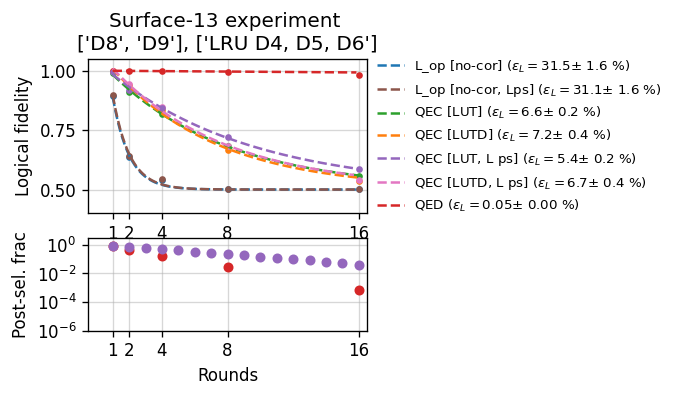

1_R Percentage of post-selected shots 0: 68.06%
1_R Percentage of post-selected shots 1: 73.31%
2_R Percentage of post-selected shots 0: 73.58%
2_R Percentage of post-selected shots 1: 70.14%
4_R Percentage of post-selected shots 0: 70.22%
4_R Percentage of post-selected shots 1: 70.30%
8_R Percentage of post-selected shots 0: 70.29%
8_R Percentage of post-selected shots 1: 70.30%
16_R Percentage of post-selected shots 0: 70.43%
16_R Percentage of post-selected shots 1: 70.57%
Logical operator (X1...X9)     :	 0.549393
Logical operator (X1...X9) PS    :	 0.542298
Logical operator (X1...X9) QED   :	 0.999900
Logical operator (X1...X9) QEC-LUT :	 0.931227
Logical operator (X1...X9) QEC-LUTD :	 0.976588
Logical operator (X1...X9) QEC-L ps :	 0.931300
Logical operator (X1...X9) QEC-LD ps :	 0.977398
Logical operator (X1...X9)     :	 -0.323951
Logical operator (X1...X9) PS    :	 -0.382900
Logical operator (X1...X9) QED   :	 0.999743
Logical operator (X1...X9) QEC-LUT :	 -0.837529
Logical op

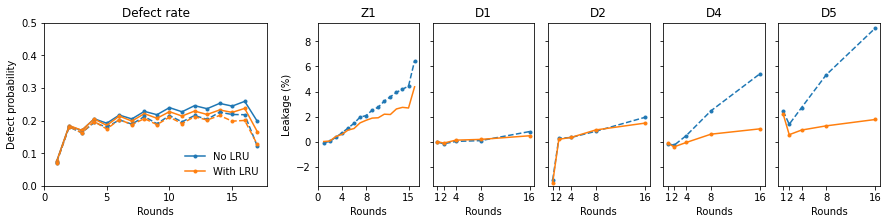

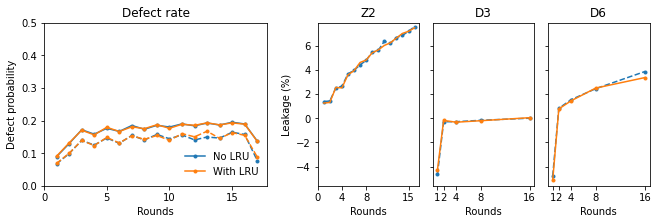

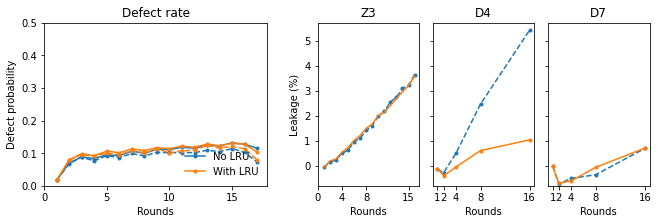

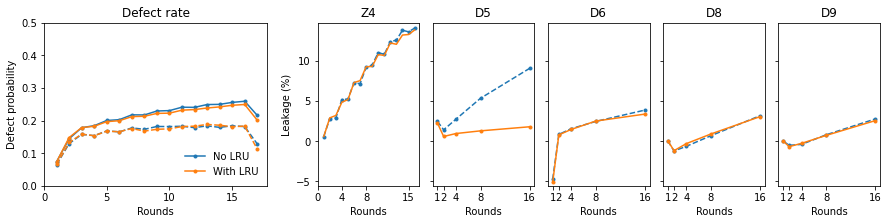

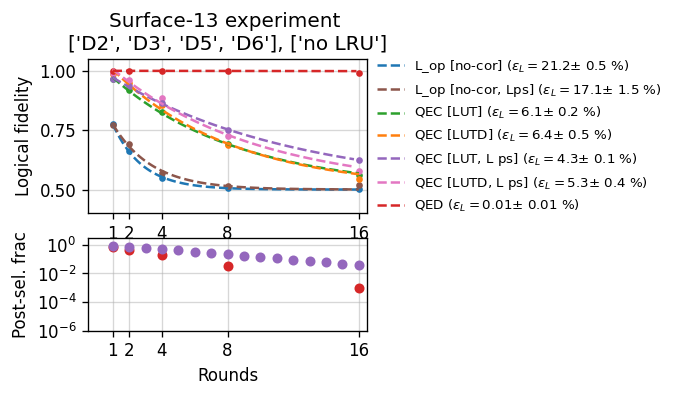

Logical operator (X1...X9)     :	 0.548297
Logical operator (X1...X9) PS    :	 0.541382
Logical operator (X1...X9) QED   :	 0.999814
Logical operator (X1...X9) QEC-LUT :	 0.932357
Logical operator (X1...X9) QEC-LUTD :	 0.977148
Logical operator (X1...X9) QEC-L ps :	 0.931537
Logical operator (X1...X9) QEC-LD ps :	 0.977302
Logical operator (X1...X9)     :	 -0.317869
Logical operator (X1...X9) PS    :	 -0.376520
Logical operator (X1...X9) QED   :	 0.999615
Logical operator (X1...X9) QEC-LUT :	 -0.831928
Logical operator (X1...X9) QEC-LUTD :	 -0.898240
Logical operator (X1...X9) QEC-L ps :	 -0.868789
Logical operator (X1...X9) QEC-LD ps :	 -0.916740
Logical operator (X1...X9)     :	 -0.092822
Logical operator (X1...X9) PS    :	 -0.118268
Logical operator (X1...X9) QED   :	 0.999027
Logical operator (X1...X9) QEC-LUT :	 -0.651847
Logical operator (X1...X9) QEC-LUTD :	 -0.699385
Logical operator (X1...X9) QEC-L ps :	 -0.720496
Logical operator (X1...X9) QEC-LD ps :	 -0.751199
Logical opera

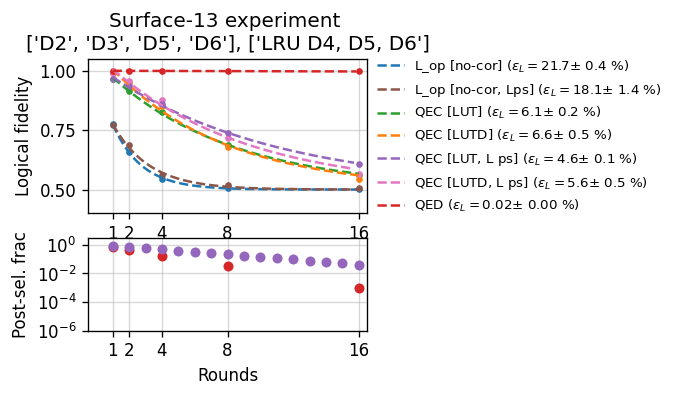

1_R Percentage of post-selected shots 0: 66.61%
1_R Percentage of post-selected shots 1: 69.94%
2_R Percentage of post-selected shots 0: 70.57%
2_R Percentage of post-selected shots 1: 68.81%
4_R Percentage of post-selected shots 0: 69.22%
4_R Percentage of post-selected shots 1: 69.21%
8_R Percentage of post-selected shots 0: 69.14%
8_R Percentage of post-selected shots 1: 69.20%
16_R Percentage of post-selected shots 0: 69.26%
16_R Percentage of post-selected shots 1: 69.55%
Logical operator (X1...X9)     :	 0.632106
Logical operator (X1...X9) PS    :	 0.638583
Logical operator (X1...X9) QED   :	 0.999968
Logical operator (X1...X9) QEC-LUT :	 0.931876
Logical operator (X1...X9) QEC-LUTD :	 0.985303
Logical operator (X1...X9) QEC-L ps :	 0.936187
Logical operator (X1...X9) QEC-LD ps :	 0.986317
Logical operator (X1...X9)     :	 -0.188627
Logical operator (X1...X9) PS    :	 -0.176359
Logical operator (X1...X9) QED   :	 0.999129
Logical operator (X1...X9) QEC-LUT :	 -0.787231
Logical op

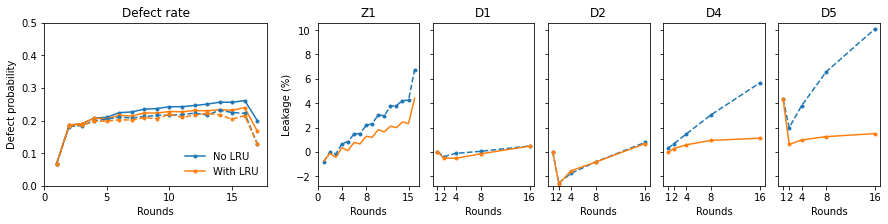

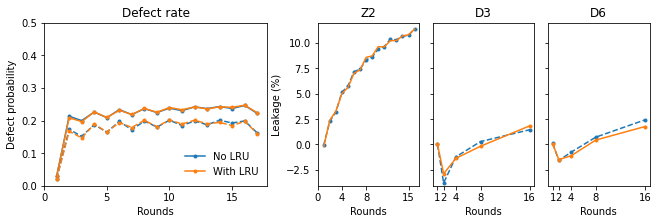

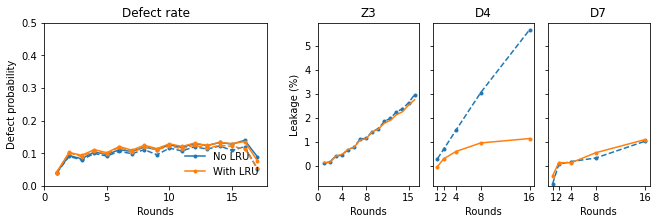

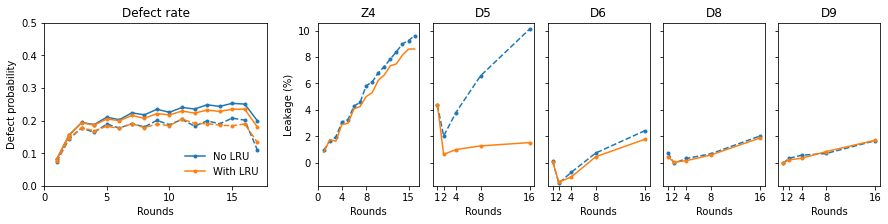

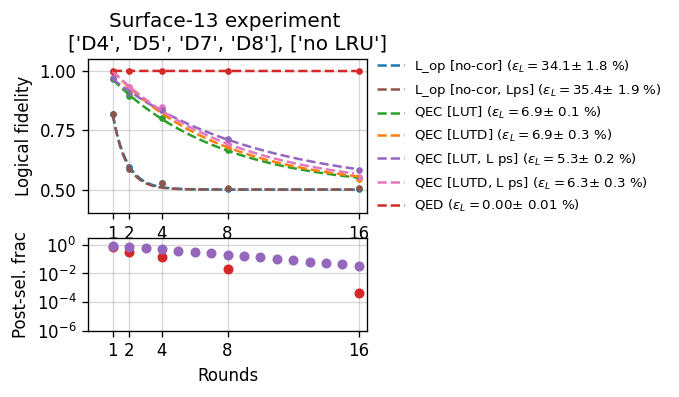

Logical operator (X1...X9)     :	 0.628425
Logical operator (X1...X9) PS    :	 0.633821
Logical operator (X1...X9) QED   :	 0.999907
Logical operator (X1...X9) QEC-LUT :	 0.930097
Logical operator (X1...X9) QEC-LUTD :	 0.984237
Logical operator (X1...X9) QEC-L ps :	 0.934626
Logical operator (X1...X9) QEC-LD ps :	 0.984856
Logical operator (X1...X9)     :	 -0.195390
Logical operator (X1...X9) PS    :	 -0.180037
Logical operator (X1...X9) QED   :	 0.999218
Logical operator (X1...X9) QEC-LUT :	 -0.790987
Logical operator (X1...X9) QEC-LUTD :	 -0.862020
Logical operator (X1...X9) QEC-L ps :	 -0.804119
Logical operator (X1...X9) QEC-LD ps :	 -0.863172
Logical operator (X1...X9)     :	 -0.052210
Logical operator (X1...X9) PS    :	 -0.048731
Logical operator (X1...X9) QED   :	 0.998364
Logical operator (X1...X9) QEC-LUT :	 -0.599566
Logical operator (X1...X9) QEC-LUTD :	 -0.651571
Logical operator (X1...X9) QEC-L ps :	 -0.647260
Logical operator (X1...X9) QEC-LD ps :	 -0.665600
Logical opera

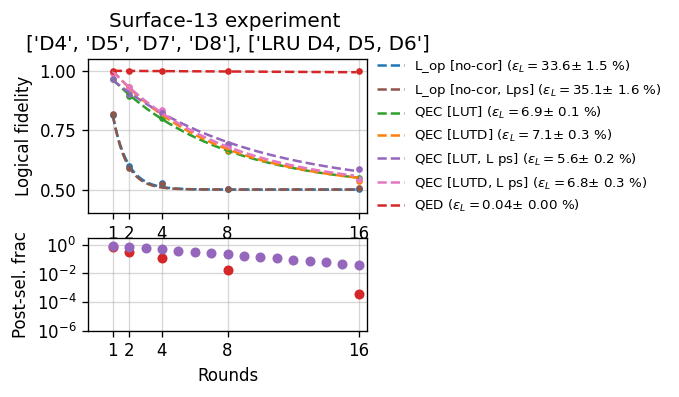

1_R Percentage of post-selected shots 0: 67.36%
1_R Percentage of post-selected shots 1: 70.38%
2_R Percentage of post-selected shots 0: 70.85%
2_R Percentage of post-selected shots 1: 69.97%
4_R Percentage of post-selected shots 0: 69.72%
4_R Percentage of post-selected shots 1: 69.77%
8_R Percentage of post-selected shots 0: 69.75%
8_R Percentage of post-selected shots 1: 69.63%
16_R Percentage of post-selected shots 0: 69.45%
16_R Percentage of post-selected shots 1: 69.59%
Logical operator (X1...X9)     :	 0.302528
Logical operator (X1...X9) PS    :	 0.264112
Logical operator (X1...X9) QED   :	 0.999699
Logical operator (X1...X9) QEC-LUT :	 0.917082
Logical operator (X1...X9) QEC-LUTD :	 0.956531
Logical operator (X1...X9) QEC-L ps :	 0.918968
Logical operator (X1...X9) QEC-LD ps :	 0.954341
Logical operator (X1...X9)     :	 -0.240116
Logical operator (X1...X9) PS    :	 -0.305621
Logical operator (X1...X9) QED   :	 0.999383
Logical operator (X1...X9) QEC-LUT :	 -0.804291
Logical op

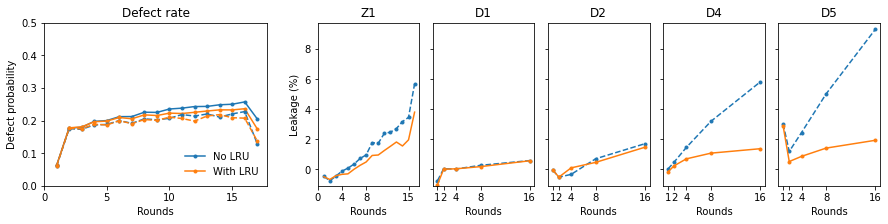

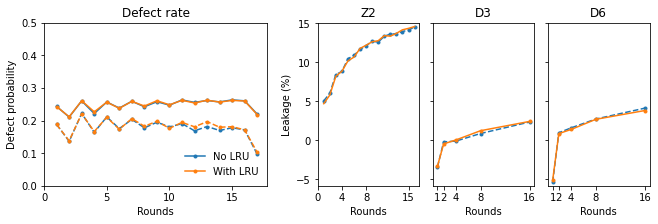

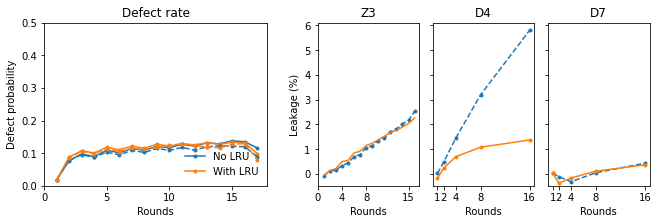

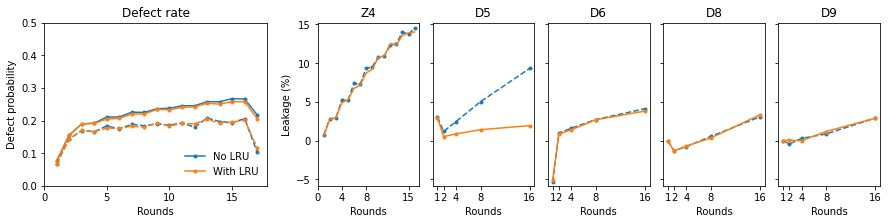

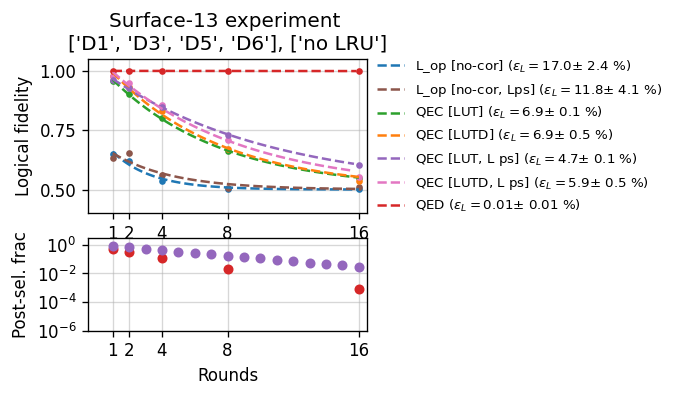

Logical operator (X1...X9)     :	 0.287261
Logical operator (X1...X9) PS    :	 0.250508
Logical operator (X1...X9) QED   :	 0.999916
Logical operator (X1...X9) QEC-LUT :	 0.913217
Logical operator (X1...X9) QEC-LUTD :	 0.954463
Logical operator (X1...X9) QEC-L ps :	 0.911247
Logical operator (X1...X9) QEC-LD ps :	 0.953196
Logical operator (X1...X9)     :	 -0.244036
Logical operator (X1...X9) PS    :	 -0.305659
Logical operator (X1...X9) QED   :	 0.999389
Logical operator (X1...X9) QEC-LUT :	 -0.802658
Logical operator (X1...X9) QEC-LUTD :	 -0.863789
Logical operator (X1...X9) QEC-L ps :	 -0.841828
Logical operator (X1...X9) QEC-LD ps :	 -0.885923
Logical operator (X1...X9)     :	 -0.061435
Logical operator (X1...X9) PS    :	 -0.094284
Logical operator (X1...X9) QED   :	 0.998938
Logical operator (X1...X9) QEC-LUT :	 -0.593262
Logical operator (X1...X9) QEC-LUTD :	 -0.651818
Logical operator (X1...X9) QEC-L ps :	 -0.674254
Logical operator (X1...X9) QEC-LD ps :	 -0.700759
Logical opera

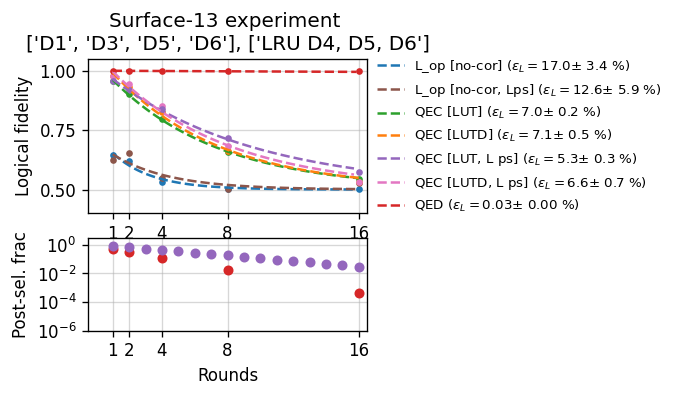

1_R Percentage of post-selected shots 0: 68.67%
1_R Percentage of post-selected shots 1: 71.32%
2_R Percentage of post-selected shots 0: 71.54%
2_R Percentage of post-selected shots 1: 71.59%
4_R Percentage of post-selected shots 0: 71.70%
4_R Percentage of post-selected shots 1: 71.63%
8_R Percentage of post-selected shots 0: 71.66%
8_R Percentage of post-selected shots 1: 71.51%
16_R Percentage of post-selected shots 0: 71.63%
16_R Percentage of post-selected shots 1: 71.36%
Logical operator (X1...X9)     :	 0.649409
Logical operator (X1...X9) PS    :	 0.668130
Logical operator (X1...X9) QED   :	 0.999969
Logical operator (X1...X9) QEC-LUT :	 0.933548
Logical operator (X1...X9) QEC-LUTD :	 0.987065
Logical operator (X1...X9) QEC-L ps :	 0.940481
Logical operator (X1...X9) QEC-LD ps :	 0.989531
Logical operator (X1...X9)     :	 -0.331697
Logical operator (X1...X9) PS    :	 -0.333734
Logical operator (X1...X9) QED   :	 0.999522
Logical operator (X1...X9) QEC-LUT :	 -0.823690
Logical op

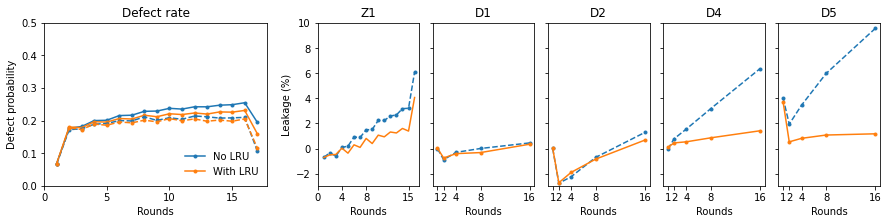

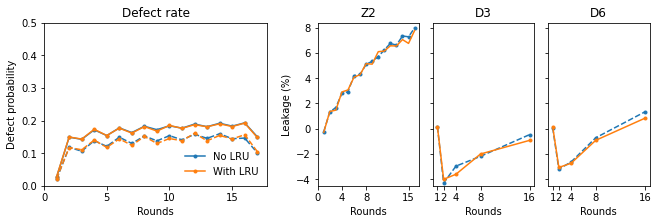

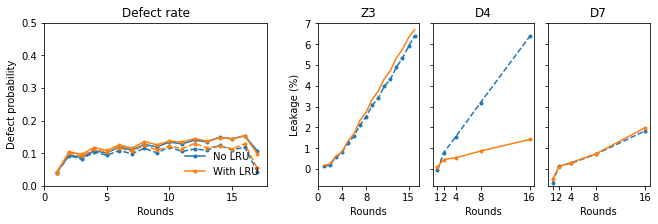

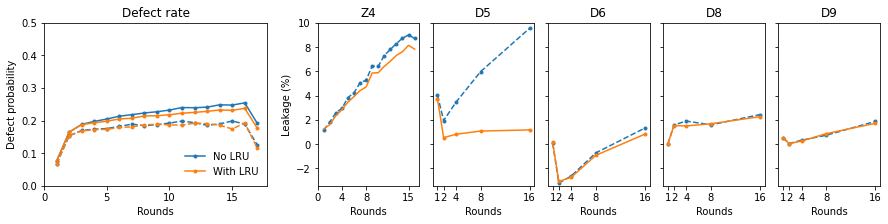

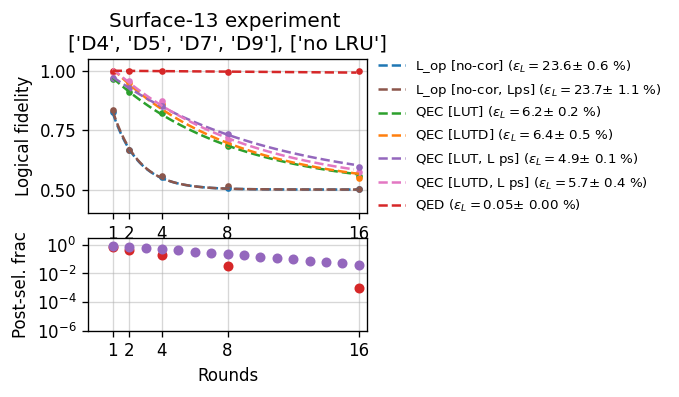

Logical operator (X1...X9)     :	 0.646799
Logical operator (X1...X9) PS    :	 0.670186
Logical operator (X1...X9) QED   :	 0.999970
Logical operator (X1...X9) QEC-LUT :	 0.933803
Logical operator (X1...X9) QEC-LUTD :	 0.986794
Logical operator (X1...X9) QEC-L ps :	 0.939746
Logical operator (X1...X9) QEC-LD ps :	 0.988997
Logical operator (X1...X9)     :	 -0.319678
Logical operator (X1...X9) PS    :	 -0.316685
Logical operator (X1...X9) QED   :	 0.999493
Logical operator (X1...X9) QEC-LUT :	 -0.817532
Logical operator (X1...X9) QEC-LUTD :	 -0.895246
Logical operator (X1...X9) QEC-L ps :	 -0.836859
Logical operator (X1...X9) QEC-LD ps :	 -0.900883
Logical operator (X1...X9)     :	 -0.099901
Logical operator (X1...X9) PS    :	 -0.106411
Logical operator (X1...X9) QED   :	 0.999180
Logical operator (X1...X9) QEC-LUT :	 -0.637077
Logical operator (X1...X9) QEC-LUTD :	 -0.705354
Logical operator (X1...X9) QEC-L ps :	 -0.688632
Logical operator (X1...X9) QEC-LD ps :	 -0.717898
Logical opera

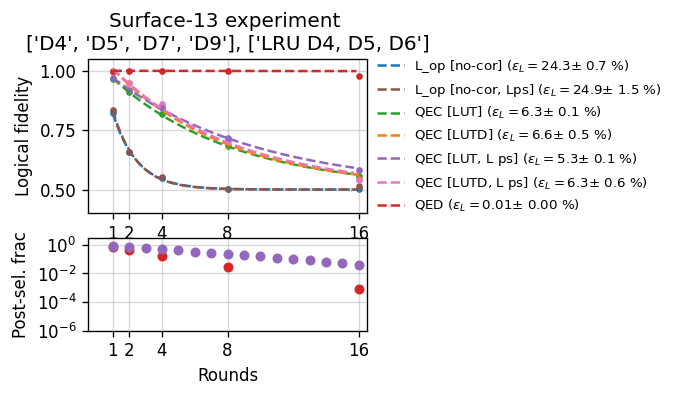

1_R Percentage of post-selected shots 0: 68.28%
1_R Percentage of post-selected shots 1: 70.52%
2_R Percentage of post-selected shots 0: 70.69%
2_R Percentage of post-selected shots 1: 72.18%
4_R Percentage of post-selected shots 0: 72.37%
4_R Percentage of post-selected shots 1: 72.17%
8_R Percentage of post-selected shots 0: 72.17%
8_R Percentage of post-selected shots 1: 72.07%
16_R Percentage of post-selected shots 0: 72.35%
16_R Percentage of post-selected shots 1: 71.67%
Logical operator (X1...X9)     :	 0.617956
Logical operator (X1...X9) PS    :	 0.629768
Logical operator (X1...X9) QED   :	 1.000000
Logical operator (X1...X9) QEC-LUT :	 0.960318
Logical operator (X1...X9) QEC-LUTD :	 0.976662
Logical operator (X1...X9) QEC-L ps :	 0.966542
Logical operator (X1...X9) QEC-LD ps :	 0.977259
Logical operator (X1...X9)     :	 -0.306286
Logical operator (X1...X9) PS    :	 -0.329597
Logical operator (X1...X9) QED   :	 0.999626
Logical operator (X1...X9) QEC-LUT :	 -0.840327
Logical op

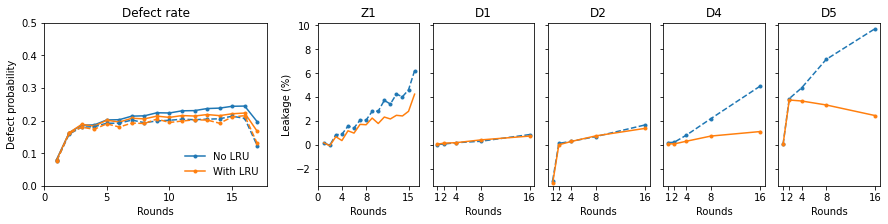

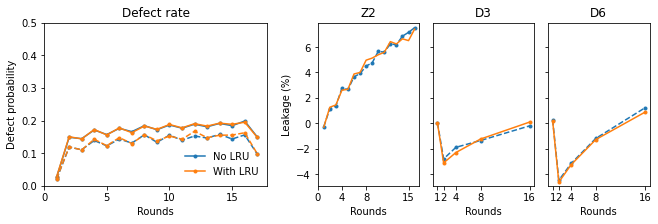

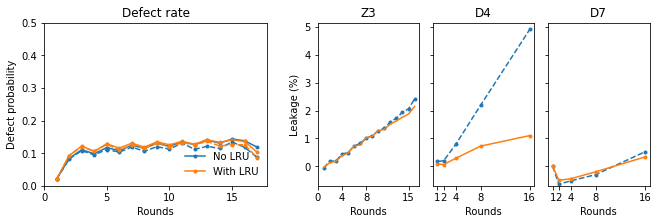

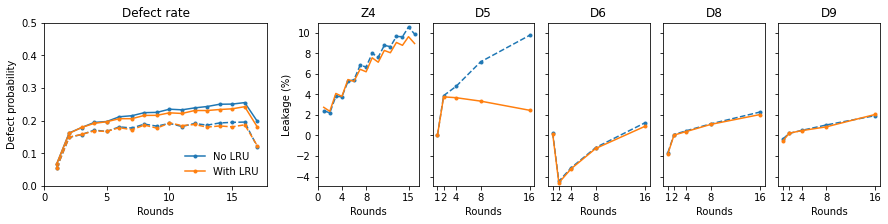

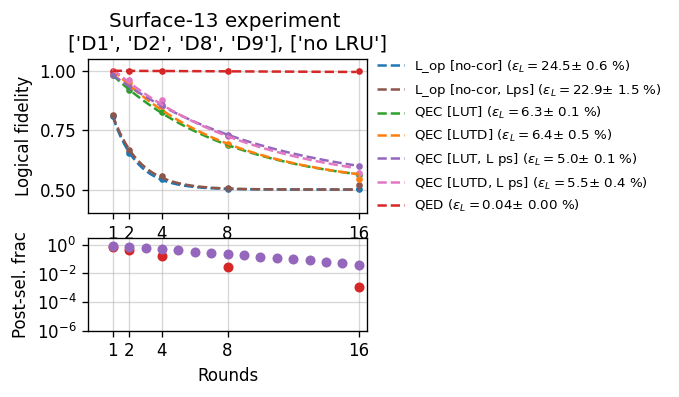

Logical operator (X1...X9)     :	 0.623332
Logical operator (X1...X9) PS    :	 0.628681
Logical operator (X1...X9) QED   :	 1.000000
Logical operator (X1...X9) QEC-LUT :	 0.961430
Logical operator (X1...X9) QEC-LUTD :	 0.977888
Logical operator (X1...X9) QEC-L ps :	 0.966972
Logical operator (X1...X9) QEC-LD ps :	 0.979616
Logical operator (X1...X9)     :	 -0.293180
Logical operator (X1...X9) PS    :	 -0.306920
Logical operator (X1...X9) QED   :	 0.999728
Logical operator (X1...X9) QEC-LUT :	 -0.835719
Logical operator (X1...X9) QEC-LUTD :	 -0.893434
Logical operator (X1...X9) QEC-L ps :	 -0.857839
Logical operator (X1...X9) QEC-LD ps :	 -0.912132
Logical operator (X1...X9)     :	 -0.081497
Logical operator (X1...X9) PS    :	 -0.098261
Logical operator (X1...X9) QED   :	 0.999368
Logical operator (X1...X9) QEC-LUT :	 -0.645212
Logical operator (X1...X9) QEC-LUTD :	 -0.689826
Logical operator (X1...X9) QEC-L ps :	 -0.688507
Logical operator (X1...X9) QEC-LD ps :	 -0.736052
Logical opera

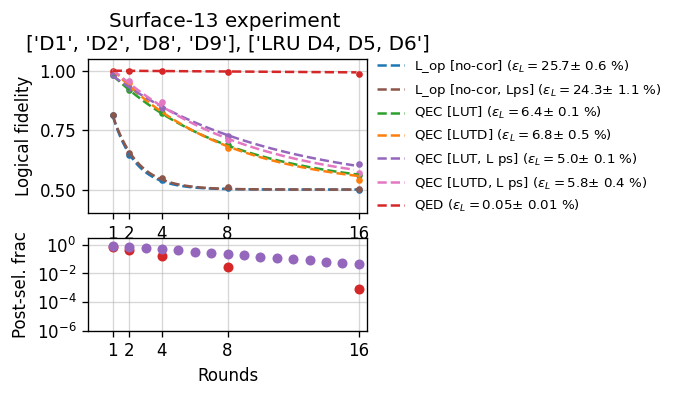

1_R Percentage of post-selected shots 0: 66.32%
1_R Percentage of post-selected shots 1: 69.90%
2_R Percentage of post-selected shots 0: 69.71%
2_R Percentage of post-selected shots 1: 68.96%
4_R Percentage of post-selected shots 0: 68.85%
4_R Percentage of post-selected shots 1: 69.02%
8_R Percentage of post-selected shots 0: 68.65%
8_R Percentage of post-selected shots 1: 68.84%
16_R Percentage of post-selected shots 0: 68.81%
16_R Percentage of post-selected shots 1: 68.87%
Logical operator (X1...X9)     :	 0.475046
Logical operator (X1...X9) PS    :	 0.468029
Logical operator (X1...X9) QED   :	 0.999586
Logical operator (X1...X9) QEC-LUT :	 0.921654
Logical operator (X1...X9) QEC-LUTD :	 0.957170
Logical operator (X1...X9) QEC-L ps :	 0.932611
Logical operator (X1...X9) QEC-LD ps :	 0.956859
Logical operator (X1...X9)     :	 -0.347604
Logical operator (X1...X9) PS    :	 -0.412106
Logical operator (X1...X9) QED   :	 0.999503
Logical operator (X1...X9) QEC-LUT :	 -0.840423
Logical op

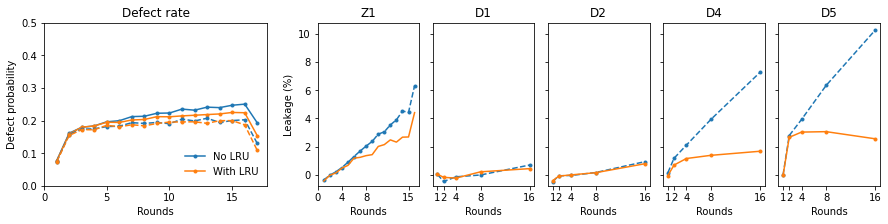

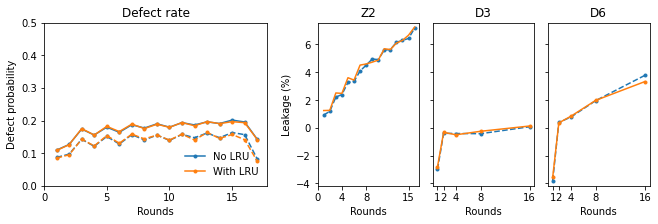

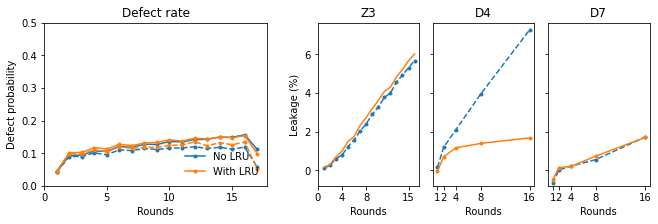

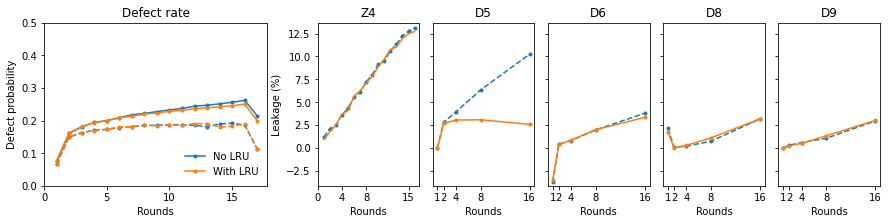

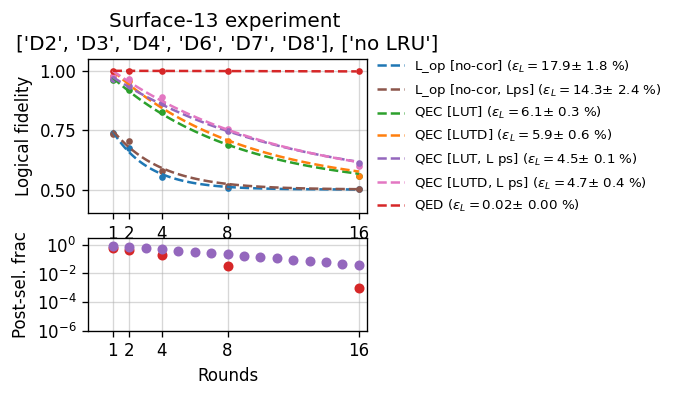

Logical operator (X1...X9)     :	 0.480049
Logical operator (X1...X9) PS    :	 0.469462
Logical operator (X1...X9) QED   :	 0.999787
Logical operator (X1...X9) QEC-LUT :	 0.923559
Logical operator (X1...X9) QEC-LUTD :	 0.957661
Logical operator (X1...X9) QEC-L ps :	 0.932503
Logical operator (X1...X9) QEC-LD ps :	 0.958657
Logical operator (X1...X9)     :	 -0.331787
Logical operator (X1...X9) PS    :	 -0.391728
Logical operator (X1...X9) QED   :	 0.999719
Logical operator (X1...X9) QEC-LUT :	 -0.834063
Logical operator (X1...X9) QEC-LUTD :	 -0.904529
Logical operator (X1...X9) QEC-L ps :	 -0.863029
Logical operator (X1...X9) QEC-LD ps :	 -0.925984
Logical operator (X1...X9)     :	 -0.102845
Logical operator (X1...X9) PS    :	 -0.148411
Logical operator (X1...X9) QED   :	 0.999203
Logical operator (X1...X9) QEC-LUT :	 -0.648459
Logical operator (X1...X9) QEC-LUTD :	 -0.713365
Logical operator (X1...X9) QEC-L ps :	 -0.709461
Logical operator (X1...X9) QEC-LD ps :	 -0.770648
Logical opera

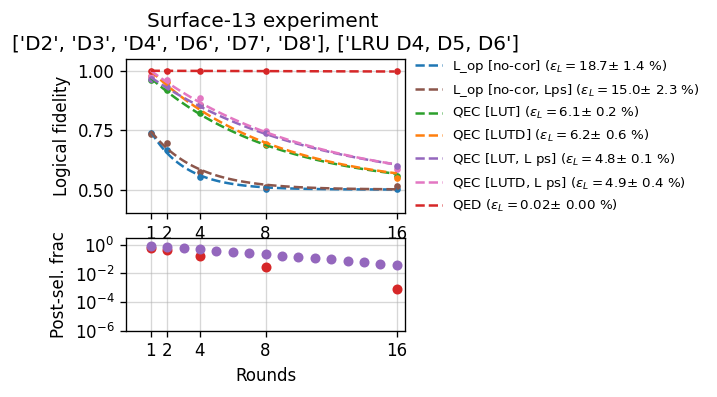

1_R Percentage of post-selected shots 0: 69.66%
1_R Percentage of post-selected shots 1: 71.29%
2_R Percentage of post-selected shots 0: 71.36%
2_R Percentage of post-selected shots 1: 72.27%
4_R Percentage of post-selected shots 0: 72.77%
4_R Percentage of post-selected shots 1: 72.91%
8_R Percentage of post-selected shots 0: 72.90%
8_R Percentage of post-selected shots 1: 72.24%
16_R Percentage of post-selected shots 0: 72.41%
16_R Percentage of post-selected shots 1: 71.98%
Logical operator (X1...X9)     :	 0.501602
Logical operator (X1...X9) PS    :	 0.511489
Logical operator (X1...X9) QED   :	 0.999512
Logical operator (X1...X9) QEC-LUT :	 0.900910
Logical operator (X1...X9) QEC-LUTD :	 0.949227
Logical operator (X1...X9) QEC-L ps :	 0.907773
Logical operator (X1...X9) QEC-LD ps :	 0.952325
Logical operator (X1...X9)     :	 -0.293752
Logical operator (X1...X9) PS    :	 -0.320251
Logical operator (X1...X9) QED   :	 0.999061
Logical operator (X1...X9) QEC-LUT :	 -0.814952
Logical op

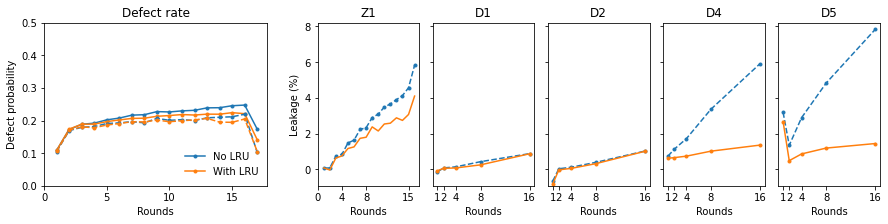

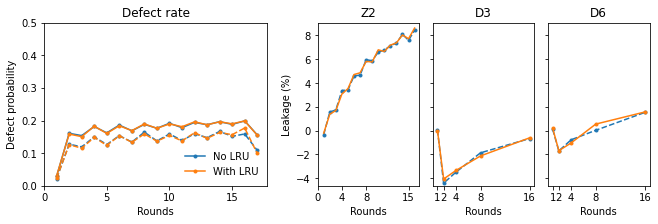

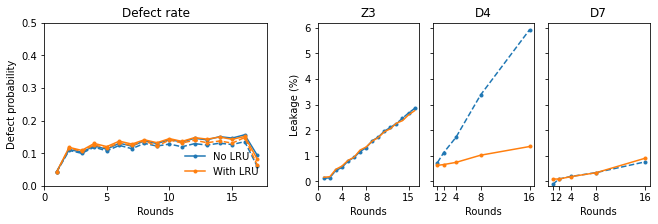

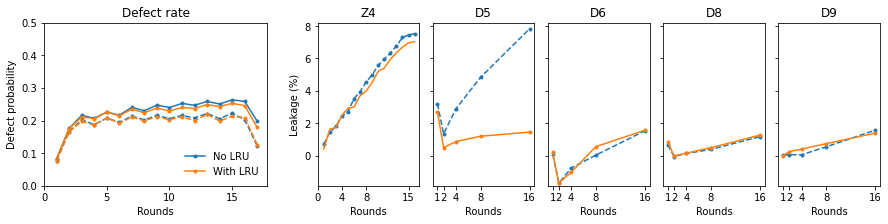

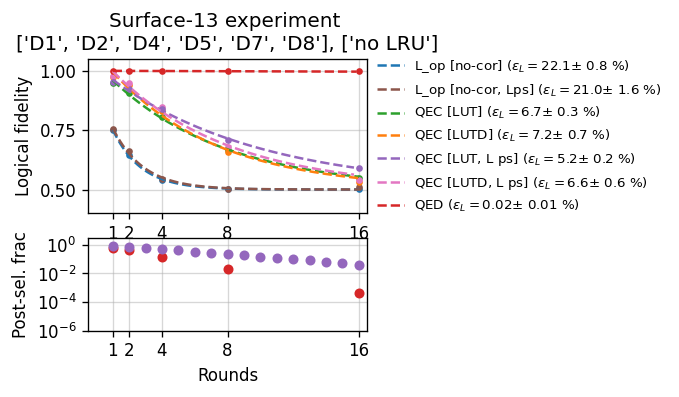

Logical operator (X1...X9)     :	 0.505640
Logical operator (X1...X9) PS    :	 0.506603
Logical operator (X1...X9) QED   :	 0.999355
Logical operator (X1...X9) QEC-LUT :	 0.903036
Logical operator (X1...X9) QEC-LUTD :	 0.950641
Logical operator (X1...X9) QEC-L ps :	 0.911203
Logical operator (X1...X9) QEC-LD ps :	 0.951709
Logical operator (X1...X9)     :	 -0.290811
Logical operator (X1...X9) PS    :	 -0.311418
Logical operator (X1...X9) QED   :	 0.999014
Logical operator (X1...X9) QEC-LUT :	 -0.813613
Logical operator (X1...X9) QEC-LUTD :	 -0.880937
Logical operator (X1...X9) QEC-L ps :	 -0.837974
Logical operator (X1...X9) QEC-LD ps :	 -0.894591
Logical operator (X1...X9)     :	 -0.069725
Logical operator (X1...X9) PS    :	 -0.086087
Logical operator (X1...X9) QED   :	 0.997947
Logical operator (X1...X9) QEC-LUT :	 -0.609445
Logical operator (X1...X9) QEC-LUTD :	 -0.653058
Logical operator (X1...X9) QEC-L ps :	 -0.657381
Logical operator (X1...X9) QEC-LD ps :	 -0.680720
Logical opera

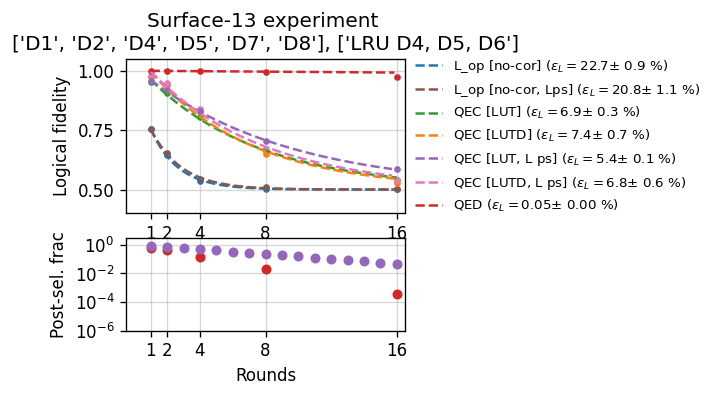

1_R Percentage of post-selected shots 0: 69.86%
1_R Percentage of post-selected shots 1: 71.89%
2_R Percentage of post-selected shots 0: 72.25%
2_R Percentage of post-selected shots 1: 71.96%
4_R Percentage of post-selected shots 0: 72.02%
4_R Percentage of post-selected shots 1: 71.96%
8_R Percentage of post-selected shots 0: 71.97%
8_R Percentage of post-selected shots 1: 71.68%
16_R Percentage of post-selected shots 0: 71.96%
16_R Percentage of post-selected shots 1: 71.82%
Logical operator (X1...X9)     :	 0.444384
Logical operator (X1...X9) PS    :	 0.421886
Logical operator (X1...X9) QED   :	 0.999375
Logical operator (X1...X9) QEC-LUT :	 0.895232
Logical operator (X1...X9) QEC-LUTD :	 0.938660
Logical operator (X1...X9) QEC-L ps :	 0.891830
Logical operator (X1...X9) QEC-LD ps :	 0.930907
Logical operator (X1...X9)     :	 -0.294156
Logical operator (X1...X9) PS    :	 -0.381940
Logical operator (X1...X9) QED   :	 0.999138
Logical operator (X1...X9) QEC-LUT :	 -0.824373
Logical op

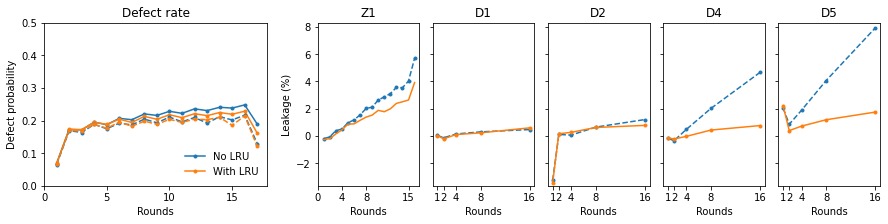

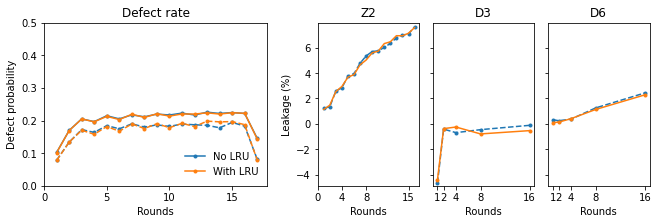

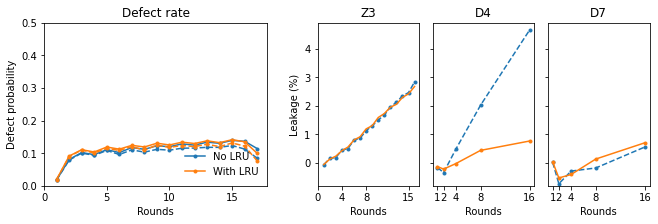

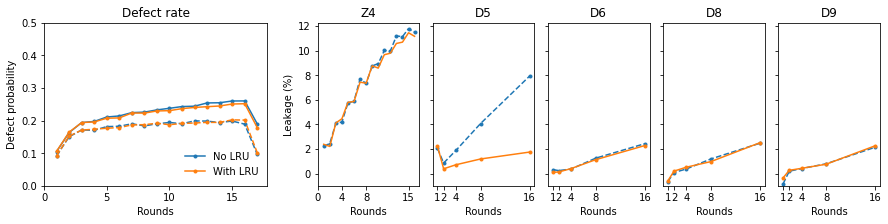

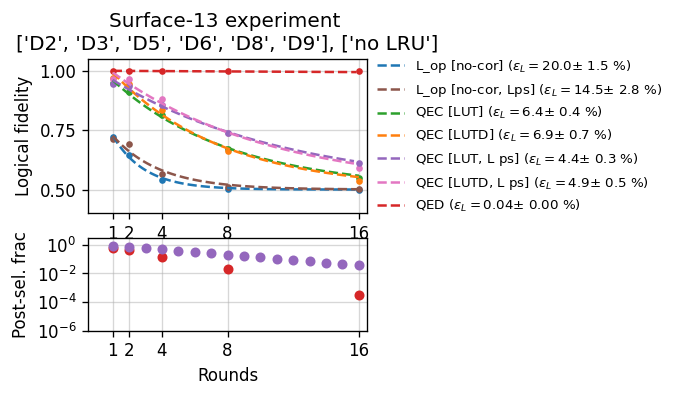

Logical operator (X1...X9)     :	 0.443307
Logical operator (X1...X9) PS    :	 0.417252
Logical operator (X1...X9) QED   :	 0.999431
Logical operator (X1...X9) QEC-LUT :	 0.899477
Logical operator (X1...X9) QEC-LUTD :	 0.939608
Logical operator (X1...X9) QEC-L ps :	 0.894900
Logical operator (X1...X9) QEC-LD ps :	 0.931176
Logical operator (X1...X9)     :	 -0.291003
Logical operator (X1...X9) PS    :	 -0.371360
Logical operator (X1...X9) QED   :	 0.999184
Logical operator (X1...X9) QEC-LUT :	 -0.820988
Logical operator (X1...X9) QEC-LUTD :	 -0.886779
Logical operator (X1...X9) QEC-L ps :	 -0.865003
Logical operator (X1...X9) QEC-LD ps :	 -0.924000
Logical operator (X1...X9)     :	 -0.071927
Logical operator (X1...X9) PS    :	 -0.114826
Logical operator (X1...X9) QED   :	 0.998558
Logical operator (X1...X9) QEC-LUT :	 -0.618602
Logical operator (X1...X9) QEC-LUTD :	 -0.661363
Logical operator (X1...X9) QEC-L ps :	 -0.712021
Logical operator (X1...X9) QEC-LD ps :	 -0.755611
Logical opera

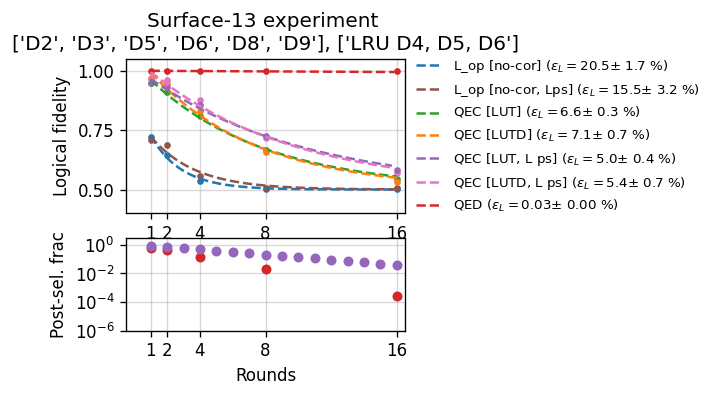

1_R Percentage of post-selected shots 0: 69.49%
1_R Percentage of post-selected shots 1: 71.17%
2_R Percentage of post-selected shots 0: 71.10%
2_R Percentage of post-selected shots 1: 71.96%
4_R Percentage of post-selected shots 0: 72.26%
4_R Percentage of post-selected shots 1: 72.23%
8_R Percentage of post-selected shots 0: 72.17%
8_R Percentage of post-selected shots 1: 71.93%
16_R Percentage of post-selected shots 0: 71.74%
16_R Percentage of post-selected shots 1: 71.46%
Logical operator (X1...X9)     :	 0.491960
Logical operator (X1...X9) PS    :	 0.480586
Logical operator (X1...X9) QED   :	 0.999754
Logical operator (X1...X9) QEC-LUT :	 0.928166
Logical operator (X1...X9) QEC-LUTD :	 0.961353
Logical operator (X1...X9) QEC-L ps :	 0.935295
Logical operator (X1...X9) QEC-LD ps :	 0.960570
Logical operator (X1...X9)     :	 -0.262831
Logical operator (X1...X9) PS    :	 -0.305007
Logical operator (X1...X9) QED   :	 0.999151
Logical operator (X1...X9) QEC-LUT :	 -0.819046
Logical op

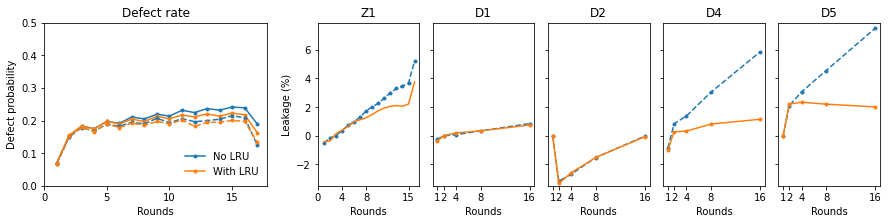

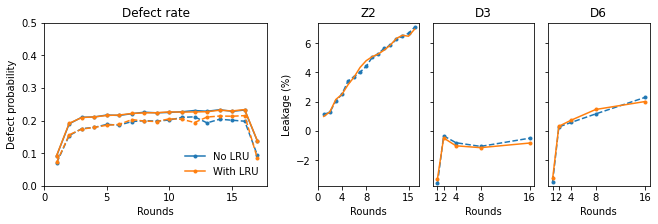

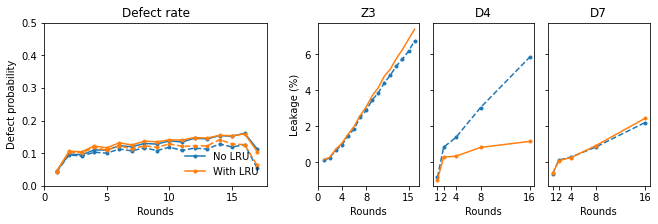

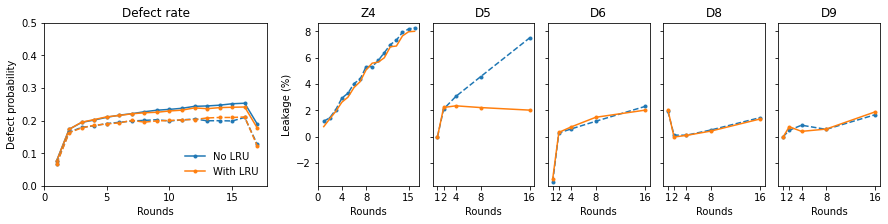

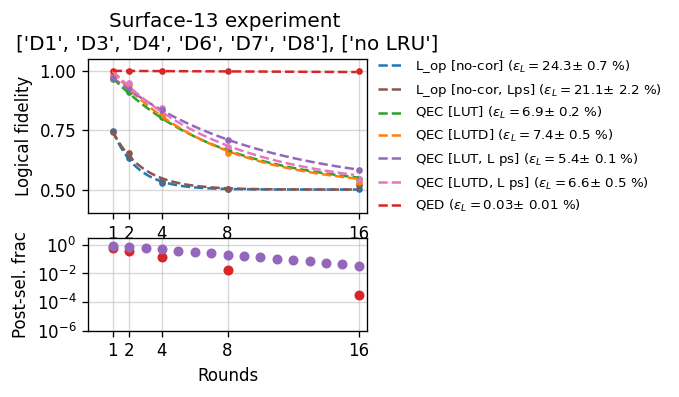

Logical operator (X1...X9)     :	 0.496326
Logical operator (X1...X9) PS    :	 0.486635
Logical operator (X1...X9) QED   :	 0.999625
Logical operator (X1...X9) QEC-LUT :	 0.925992
Logical operator (X1...X9) QEC-LUTD :	 0.958856
Logical operator (X1...X9) QEC-L ps :	 0.927995
Logical operator (X1...X9) QEC-LD ps :	 0.956987
Logical operator (X1...X9)     :	 -0.255980
Logical operator (X1...X9) PS    :	 -0.303424
Logical operator (X1...X9) QED   :	 0.999031
Logical operator (X1...X9) QEC-LUT :	 -0.817065
Logical operator (X1...X9) QEC-LUTD :	 -0.873509
Logical operator (X1...X9) QEC-L ps :	 -0.839923
Logical operator (X1...X9) QEC-LD ps :	 -0.888374
Logical operator (X1...X9)     :	 -0.054547
Logical operator (X1...X9) PS    :	 -0.075132
Logical operator (X1...X9) QED   :	 0.998258
Logical operator (X1...X9) QEC-LUT :	 -0.605933
Logical operator (X1...X9) QEC-LUTD :	 -0.631744
Logical operator (X1...X9) QEC-L ps :	 -0.664538
Logical operator (X1...X9) QEC-LD ps :	 -0.677629
Logical opera

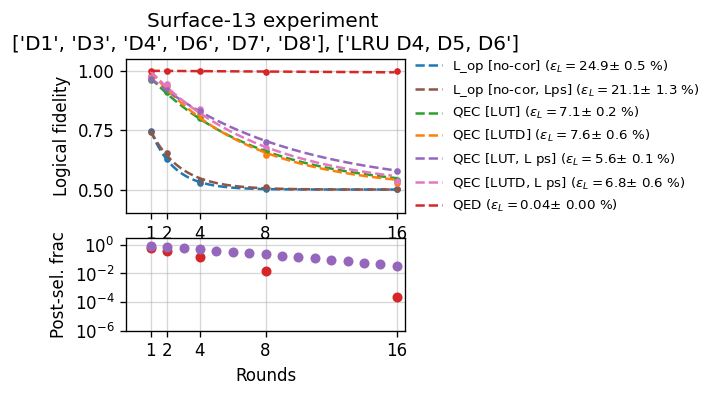

1_R Percentage of post-selected shots 0: 67.62%
1_R Percentage of post-selected shots 1: 69.89%
2_R Percentage of post-selected shots 0: 70.13%
2_R Percentage of post-selected shots 1: 71.34%
4_R Percentage of post-selected shots 0: 71.63%
4_R Percentage of post-selected shots 1: 71.50%
8_R Percentage of post-selected shots 0: 71.50%
8_R Percentage of post-selected shots 1: 71.35%
16_R Percentage of post-selected shots 0: 71.43%
16_R Percentage of post-selected shots 1: 70.77%
Logical operator (X1...X9)     :	 0.456708
Logical operator (X1...X9) PS    :	 0.453640
Logical operator (X1...X9) QED   :	 0.999774
Logical operator (X1...X9) QEC-LUT :	 0.916672
Logical operator (X1...X9) QEC-LUTD :	 0.951306
Logical operator (X1...X9) QEC-L ps :	 0.924486
Logical operator (X1...X9) QEC-LD ps :	 0.953330
Logical operator (X1...X9)     :	 -0.289226
Logical operator (X1...X9) PS    :	 -0.347263
Logical operator (X1...X9) QED   :	 0.999381
Logical operator (X1...X9) QEC-LUT :	 -0.818159
Logical op

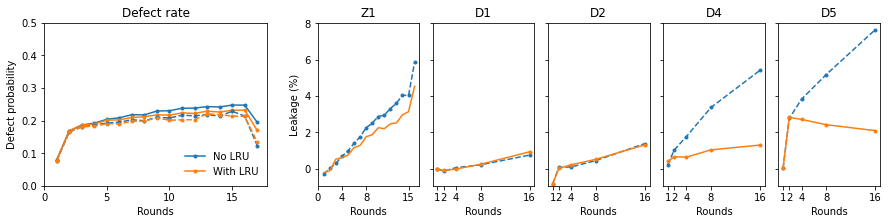

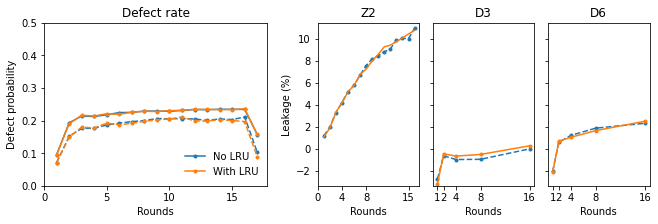

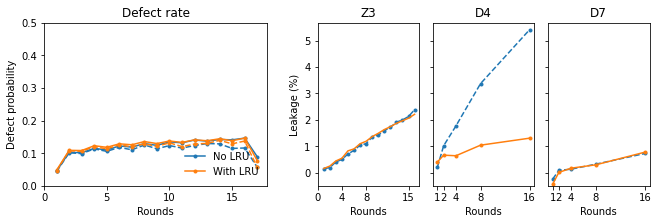

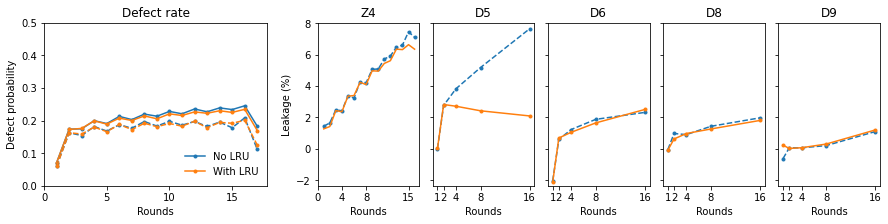

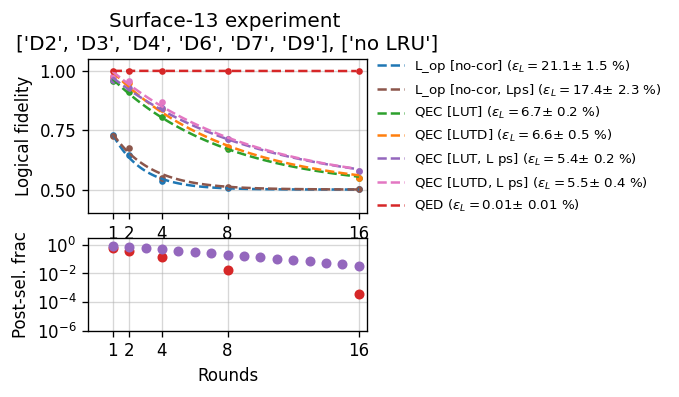

Logical operator (X1...X9)     :	 0.457818
Logical operator (X1...X9) PS    :	 0.457035
Logical operator (X1...X9) QED   :	 0.999710
Logical operator (X1...X9) QEC-LUT :	 0.916402
Logical operator (X1...X9) QEC-LUTD :	 0.952528
Logical operator (X1...X9) QEC-L ps :	 0.925262
Logical operator (X1...X9) QEC-LD ps :	 0.954989
Logical operator (X1...X9)     :	 -0.286414
Logical operator (X1...X9) PS    :	 -0.350264
Logical operator (X1...X9) QED   :	 0.999408
Logical operator (X1...X9) QEC-LUT :	 -0.817344
Logical operator (X1...X9) QEC-LUTD :	 -0.890277
Logical operator (X1...X9) QEC-L ps :	 -0.844350
Logical operator (X1...X9) QEC-LD ps :	 -0.909706
Logical operator (X1...X9)     :	 -0.060965
Logical operator (X1...X9) PS    :	 -0.095114
Logical operator (X1...X9) QED   :	 0.998540
Logical operator (X1...X9) QEC-LUT :	 -0.613506
Logical operator (X1...X9) QEC-LUTD :	 -0.667218
Logical operator (X1...X9) QEC-L ps :	 -0.673740
Logical operator (X1...X9) QEC-LD ps :	 -0.729803
Logical opera

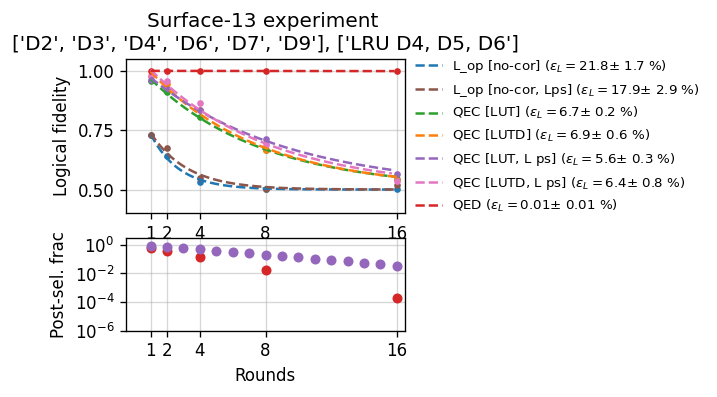

1_R Percentage of post-selected shots 0: 68.63%
1_R Percentage of post-selected shots 1: 70.35%
2_R Percentage of post-selected shots 0: 70.78%
2_R Percentage of post-selected shots 1: 72.25%
4_R Percentage of post-selected shots 0: 72.27%
4_R Percentage of post-selected shots 1: 72.29%
8_R Percentage of post-selected shots 0: 72.18%
8_R Percentage of post-selected shots 1: 72.02%
16_R Percentage of post-selected shots 0: 71.93%
16_R Percentage of post-selected shots 1: 71.56%
Logical operator (X1...X9)     :	 0.499946
Logical operator (X1...X9) PS    :	 0.483730
Logical operator (X1...X9) QED   :	 0.999754
Logical operator (X1...X9) QEC-LUT :	 0.910565
Logical operator (X1...X9) QEC-LUTD :	 0.950870
Logical operator (X1...X9) QEC-L ps :	 0.911820
Logical operator (X1...X9) QEC-LD ps :	 0.947729
Logical operator (X1...X9)     :	 -0.238462
Logical operator (X1...X9) PS    :	 -0.304333
Logical operator (X1...X9) QED   :	 0.999352
Logical operator (X1...X9) QEC-LUT :	 -0.815323
Logical op

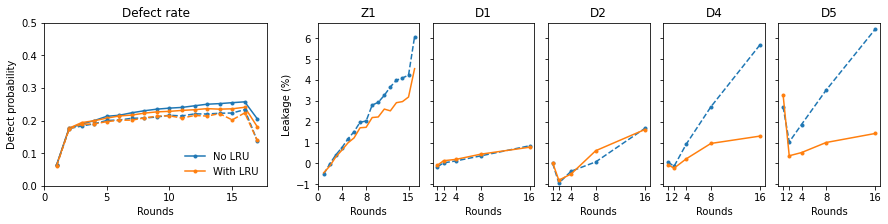

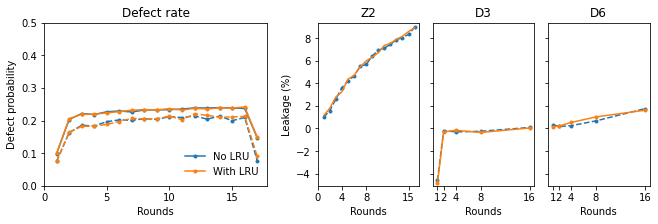

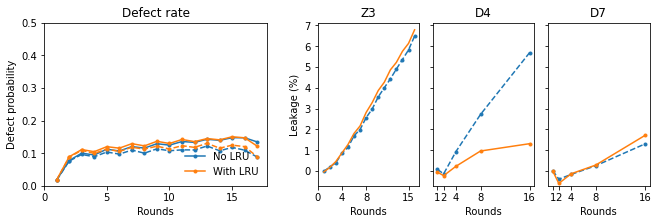

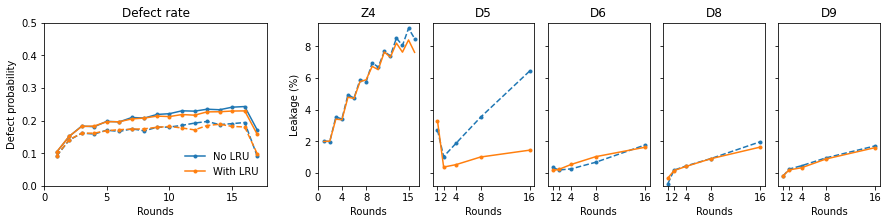

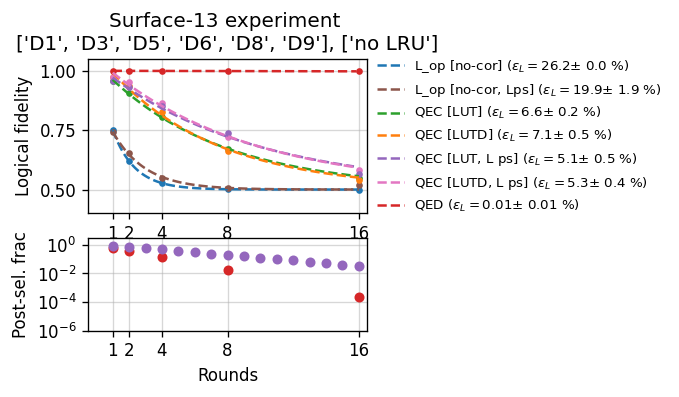

Logical operator (X1...X9)     :	 0.497303
Logical operator (X1...X9) PS    :	 0.484256
Logical operator (X1...X9) QED   :	 0.999554
Logical operator (X1...X9) QEC-LUT :	 0.909672
Logical operator (X1...X9) QEC-LUTD :	 0.953028
Logical operator (X1...X9) QEC-L ps :	 0.907102
Logical operator (X1...X9) QEC-LD ps :	 0.948964
Logical operator (X1...X9)     :	 -0.237425
Logical operator (X1...X9) PS    :	 -0.297110
Logical operator (X1...X9) QED   :	 0.999152
Logical operator (X1...X9) QEC-LUT :	 -0.811843
Logical operator (X1...X9) QEC-LUTD :	 -0.869565
Logical operator (X1...X9) QEC-L ps :	 -0.853350
Logical operator (X1...X9) QEC-LD ps :	 -0.902494
Logical operator (X1...X9)     :	 -0.046219
Logical operator (X1...X9) PS    :	 -0.078251
Logical operator (X1...X9) QED   :	 0.998030
Logical operator (X1...X9) QEC-LUT :	 -0.609909
Logical operator (X1...X9) QEC-LUTD :	 -0.638746
Logical operator (X1...X9) QEC-L ps :	 -0.688929
Logical operator (X1...X9) QEC-LD ps :	 -0.706576
Logical opera

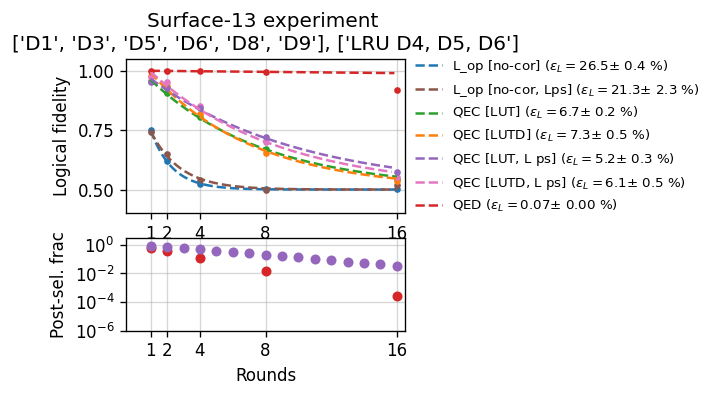

1_R Percentage of post-selected shots 0: 68.90%
1_R Percentage of post-selected shots 1: 70.11%
2_R Percentage of post-selected shots 0: 70.13%
2_R Percentage of post-selected shots 1: 72.12%
4_R Percentage of post-selected shots 0: 72.39%
4_R Percentage of post-selected shots 1: 72.44%
8_R Percentage of post-selected shots 0: 72.64%
8_R Percentage of post-selected shots 1: 72.21%
16_R Percentage of post-selected shots 0: 72.18%
16_R Percentage of post-selected shots 1: 71.89%
Logical operator (X1...X9)     :	 0.480668
Logical operator (X1...X9) PS    :	 0.493552
Logical operator (X1...X9) QED   :	 0.999174
Logical operator (X1...X9) QEC-LUT :	 0.892463
Logical operator (X1...X9) QEC-LUTD :	 0.944331
Logical operator (X1...X9) QEC-L ps :	 0.904063
Logical operator (X1...X9) QEC-LD ps :	 0.950359
Logical operator (X1...X9)     :	 -0.273061
Logical operator (X1...X9) PS    :	 -0.282047
Logical operator (X1...X9) QED   :	 0.998564
Logical operator (X1...X9) QEC-LUT :	 -0.810845
Logical op

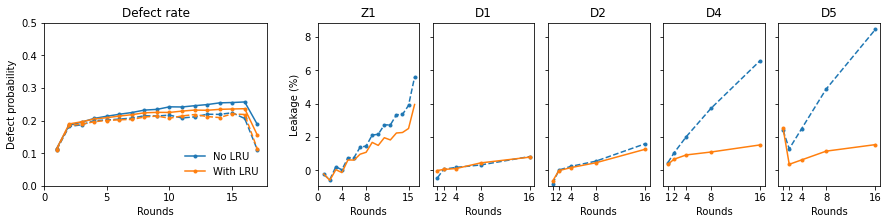

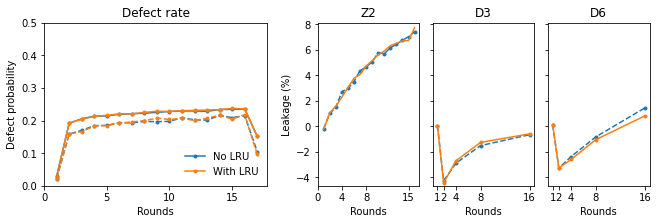

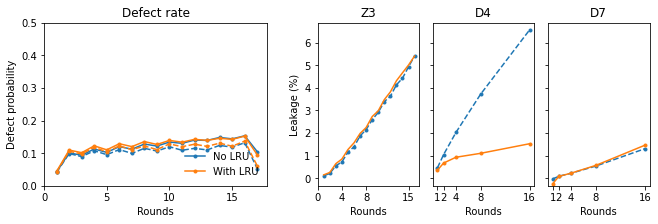

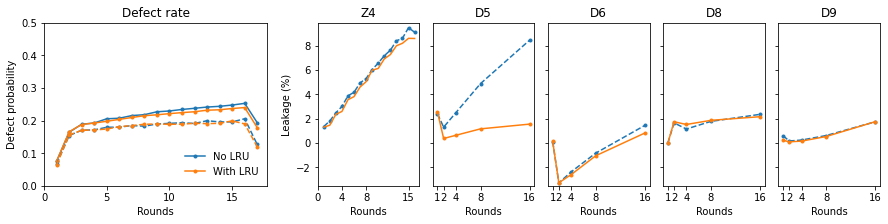

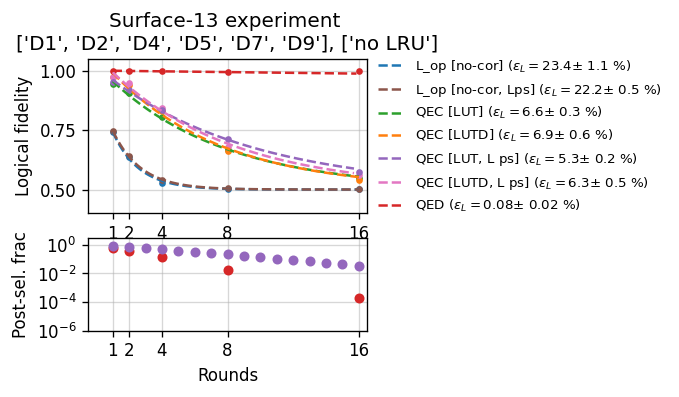

Logical operator (X1...X9)     :	 0.478673
Logical operator (X1...X9) PS    :	 0.490536
Logical operator (X1...X9) QED   :	 0.999116
Logical operator (X1...X9) QEC-LUT :	 0.894427
Logical operator (X1...X9) QEC-LUTD :	 0.940646
Logical operator (X1...X9) QEC-L ps :	 0.905308
Logical operator (X1...X9) QEC-LD ps :	 0.943904
Logical operator (X1...X9)     :	 -0.267594
Logical operator (X1...X9) PS    :	 -0.282620
Logical operator (X1...X9) QED   :	 0.999030
Logical operator (X1...X9) QEC-LUT :	 -0.807734
Logical operator (X1...X9) QEC-LUTD :	 -0.879999
Logical operator (X1...X9) QEC-L ps :	 -0.828612
Logical operator (X1...X9) QEC-LD ps :	 -0.890151
Logical operator (X1...X9)     :	 -0.048298
Logical operator (X1...X9) PS    :	 -0.044038
Logical operator (X1...X9) QED   :	 0.997906
Logical operator (X1...X9) QEC-LUT :	 -0.600739
Logical operator (X1...X9) QEC-LUTD :	 -0.649006
Logical operator (X1...X9) QEC-L ps :	 -0.643867
Logical operator (X1...X9) QEC-LD ps :	 -0.670493
Logical opera

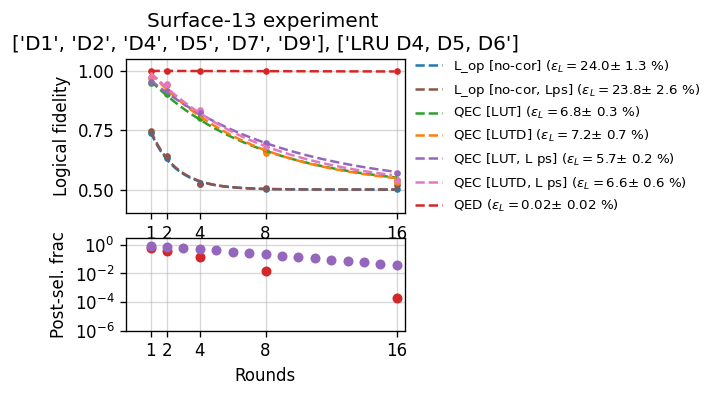

1_R Percentage of post-selected shots 0: 70.05%
1_R Percentage of post-selected shots 1: 71.35%
2_R Percentage of post-selected shots 0: 71.16%
2_R Percentage of post-selected shots 1: 73.20%
4_R Percentage of post-selected shots 0: 73.47%
4_R Percentage of post-selected shots 1: 73.47%
8_R Percentage of post-selected shots 0: 73.40%
8_R Percentage of post-selected shots 1: 73.27%
16_R Percentage of post-selected shots 0: 72.88%
16_R Percentage of post-selected shots 1: 72.64%
Logical operator (X1...X9)     :	 0.493803
Logical operator (X1...X9) PS    :	 0.490358
Logical operator (X1...X9) QED   :	 0.999654
Logical operator (X1...X9) QEC-LUT :	 0.925705
Logical operator (X1...X9) QEC-LUTD :	 0.960559
Logical operator (X1...X9) QEC-L ps :	 0.933934
Logical operator (X1...X9) QEC-LD ps :	 0.959779
Logical operator (X1...X9)     :	 -0.267516
Logical operator (X1...X9) PS    :	 -0.314662
Logical operator (X1...X9) QED   :	 0.999373
Logical operator (X1...X9) QEC-LUT :	 -0.821573
Logical op

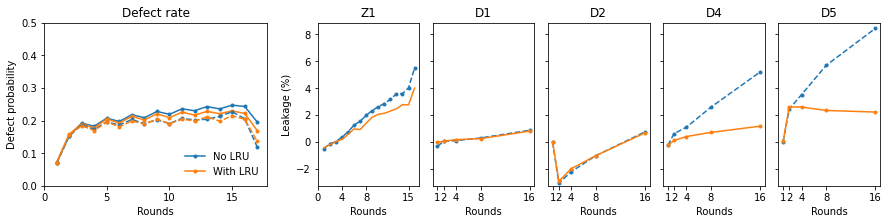

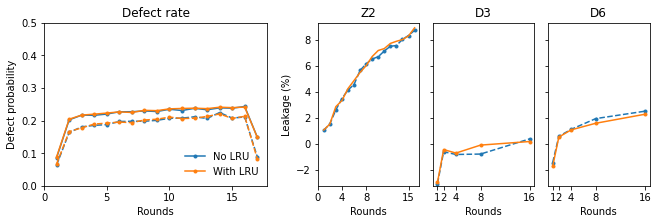

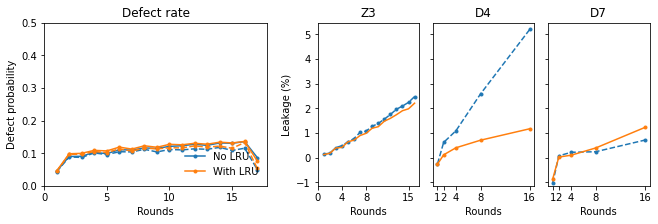

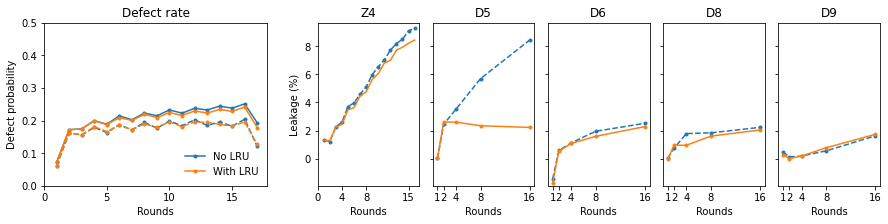

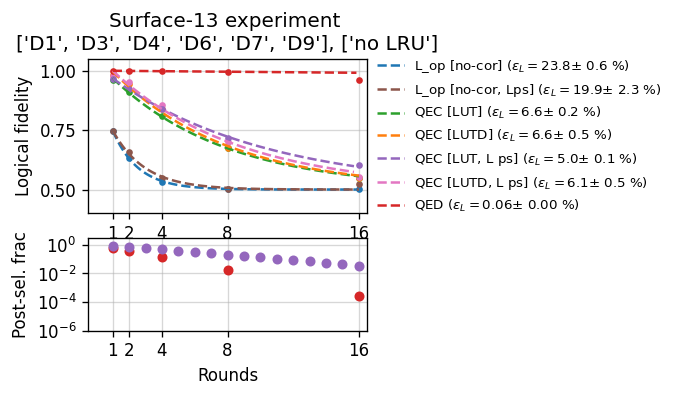

Logical operator (X1...X9)     :	 0.499953
Logical operator (X1...X9) PS    :	 0.494640
Logical operator (X1...X9) QED   :	 0.999763
Logical operator (X1...X9) QEC-LUT :	 0.925559
Logical operator (X1...X9) QEC-LUTD :	 0.958171
Logical operator (X1...X9) QEC-L ps :	 0.930684
Logical operator (X1...X9) QEC-LD ps :	 0.956109
Logical operator (X1...X9)     :	 -0.265902
Logical operator (X1...X9) PS    :	 -0.307958
Logical operator (X1...X9) QED   :	 0.999199
Logical operator (X1...X9) QEC-LUT :	 -0.817055
Logical operator (X1...X9) QEC-LUTD :	 -0.883924
Logical operator (X1...X9) QEC-L ps :	 -0.844032
Logical operator (X1...X9) QEC-LD ps :	 -0.900531
Logical operator (X1...X9)     :	 -0.059040
Logical operator (X1...X9) PS    :	 -0.089815
Logical operator (X1...X9) QED   :	 0.998370
Logical operator (X1...X9) QEC-LUT :	 -0.614431
Logical operator (X1...X9) QEC-LUTD :	 -0.657706
Logical operator (X1...X9) QEC-L ps :	 -0.664901
Logical operator (X1...X9) QEC-LD ps :	 -0.698531
Logical opera

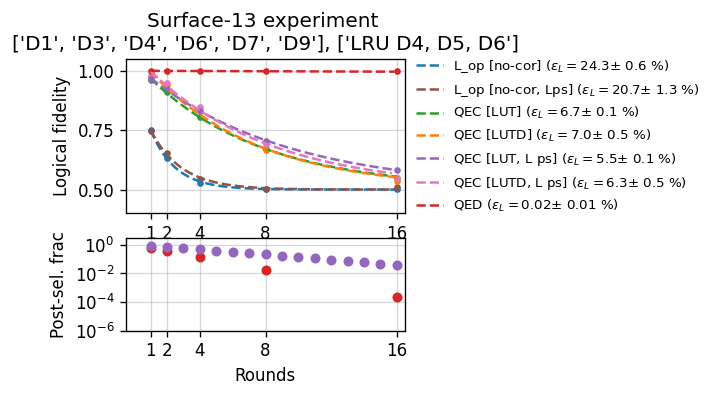

In [11]:
# run the Analysis to get defect rate & pij matrix.
ancilla_qubits = ['Z1', 'Z2', 'Z3', 'Z4']
data_qubits = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']
n_kernels = 2
heralded_init = True
Rounds = [1, 2, 4, 8, 16]
states = [
    [],							  # I
    ['D1','D2'], 					  # X1
    ['D8','D9'], 					  # X4
    ['D2','D3','D5','D6'], 		  # X2
    ['D4','D5','D7','D8'], 		  # X3
    ['D1','D3','D5','D6'], 		  # X1 X2
    ['D4','D5','D7','D9'], 		  # X3 X4
    ['D1','D2','D8','D9'], 		  # X1 X4
    ['D2','D3','D4','D6','D7','D8'], # X2 X3 
    ['D1','D2','D4','D5','D7','D8'], # X1 X3
    ['D2','D3','D5','D6','D8','D9'], # X2 X4
    ['D1','D3','D4','D6','D7','D8'], # X1 X2 X3
    ['D2','D3','D4','D6','D7','D9'], # X2 X3 X4
    ['D1','D3','D5','D6','D8','D9'], # X1 X2 X4
    ['D1','D2','D4','D5','D7','D9'], # X1 X3 X4
    ['D1','D3','D4','D6','D7','D9'],  # X1 X2 X3 X4
]
keys = [['no LRU'], ['LRU D4, D5, D6']]
LOG_OP =  { f'{state}' : { k:{} for k in range(n_kernels) } for state in states }
LOG_OP_PS =  { f'{state}' : { k:{} for k in range(n_kernels) } for state in states }
LOG_OP_QEC = { f'{state}' : { k:{} for k in range(n_kernels) } for state in states }
LOG_OP_QED = { f'{state}' : { k:{} for k in range(n_kernels) } for state in states }
PS_FRACTION = { f'{state}' : { k:{} for k in range(n_kernels) } for state in states }
LOG_OP_QEC_D = { f'{state}' : { k:{} for k in range(n_kernels) } for state in states }
LOG_OP_QEC_D_F = { f'{state}' : { k:{} for k in range(n_kernels) } for state in states }
LOG_OP_QEC_ps = { f'{state}' : { k:{} for k in range(n_kernels) } for state in states }
PS_FRACTION_PS = { f'{state}' : { k:{} for k in range(n_kernels) } for state in states }
defects = {} 
for anc in ancilla_qubits:
    defects[anc] = {}
    for state in states:
        defects[anc][f'{state}'] =  {}
        for k in range(n_kernels):
            defects[anc][f'{state}'][k] = np.zeros(Rounds[-1])
defects_f = {} 
for anc in ancilla_qubits:
    defects_f[anc] = {}
    for state in states:
        defects_f[anc][f'{state}'] =  {}
        for k in range(n_kernels):
            defects_f[anc][f'{state}'][k] =  np.zeros(Rounds[-1])
for state in states:
    ##########################################################
    # Sorting and analyzing data
    ##########################################################
    # Analyze calibration data
    raw_data_dict = np.load(f'./Raw_data_dict_{state}_V3_5.npy', allow_pickle=True).item()
    proc_data_dict = Analyze_calibration_shots(raw_data_dict, Rounds, n_kernels, heralded_init)
    # Sort and bin experiment shots
    proc_data_dict = Sort_and_analyze_experiment_shots(proc_data_dict, Rounds, n_kernels, heralded_init)
    # Calculate leakage population
    Population, Population_f = Calculate_leakage_population(proc_data_dict, Rounds, n_kernels)
    ##########################################################
    # Extracting syndrome and logical outcome information
    ##########################################################
    # Compute Defects for each stabilizer
    Defects, Defects_f, Defects_MV, Defects_MV_f, Defect_rate, Defect_rate_f = \
        Compute_defects(proc_data_dict, Rounds, n_kernels)

    for stab in ['Z1', 'Z2', 'Z3', 'Z4']:
        _plot_defect_rate_and_leakage(
            stab,
            Rounds,
            Defect_rate,
            Population_f,
            Defect_rate_f = Defect_rate_f, # plot ps on ancilla leakage 
            )
    for k in range(n_kernels):
        # quantities of interest
        PS_fraction = []
        L = [] 
        L_ps = [] 
        L_QEC= []
        L_QEC_D = []
        L_QEC_D_f = []
        L_QED = []
        L_QEC_ps = []
        shots_per_exp = proc_data_dict['Shots_qubit'][k]
        shots_per_exp_ps = proc_data_dict['Shots_qubit_ps'][k]
        Leakage_ps = proc_data_dict['L_PS'][k]
        Leakage_ps[-1]= Leakage_ps[-1]*Ps_fraction_L_D[k]
        Shots_for_QED = deepcopy(proc_data_dict['Shots_qubit'][k])
        for qubit in data_qubits+ancilla_qubits: 
            for R in Rounds:
                for r in range(1,R+1):
                    Shots_for_QED[qubit][f'{R}_R'][f'round {r}'] = (1-2*Shots_for_QED[qubit][f'{R}_R'][f'round {r}'])
        for r in Rounds:
            if r != 0:
                S_values = {anc : (1-Defects[anc][k][f'{r}_R'])/2 for anc in ancilla_qubits }
                S_values_MV = {anc : (1-Defects_MV[anc][k][f'{r}_R'])/2 for anc in ancilla_qubits }
                S_values_ps = {anc : (1-Defects_f[anc][k][f'{r}_R'][~np.isnan(Defects_f[anc][k][f'{r}_R']).any(axis=1)])/2 for anc in ancilla_qubits }
                S_values_MV_f = {anc : (1-Defects_MV_f[anc][k][f'{r}_R'][~np.isnan(Defects_MV_f[anc][k][f'{r}_R']).any(axis=1)])/2 for anc in ancilla_qubits }
                pauli_frame = _pauli_frame_update(S_values,r,ancilla_qubits)
                pauli_frame_MV = _pauli_frame_update(S_values_MV,r,ancilla_qubits)
                pauli_frame_ps = _pauli_frame_update(S_values_ps,r,ancilla_qubits)
                pauli_frame_MV_f = _pauli_frame_update(S_values_MV_f,r,ancilla_qubits)
                Log_op = _compute_logical_operator_shots(data_qubits ,shots_per_exp, r)
                Log_op_ps = _compute_logical_operator_shots(data_qubits ,shots_per_exp_ps, r)
                L_QED.append(np.abs(np.mean(_QED_ps(r, Shots_for_QED,ancilla_qubits, data_qubits)[0]))) # PS for QED
                PS_fraction.append(_QED_ps(r, Shots_for_QED, ancilla_qubits, data_qubits)[1]) # PS for QED 
                Log_op_QEC = np.mean(Log_op*pauli_frame)
                Log_op_QEC_D = np.mean(Log_op*pauli_frame_MV)
                Log_op_QEC_D_f = np.mean(Log_op_ps*pauli_frame_MV_f)
                Log_op_QEC_ps = np.mean(Log_op_ps*pauli_frame_ps)
                L.append(np.mean(Log_op))
                L_ps.append(np.mean(Log_op_ps))
                L_QEC.append(Log_op_QEC)
                L_QEC_D.append(Log_op_QEC_D)
                L_QEC_D_f.append(Log_op_QEC_D_f)
                L_QEC_ps.append(Log_op_QEC_ps)
                print('Logical operator (X1...X9)     :\t {:f}'.format(np.mean(Log_op)))
                print('Logical operator (X1...X9) PS    :\t {:f}'.format(np.mean(Log_op_ps)))
                print('Logical operator (X1...X9) QED   :\t {:f}'.format(np.mean(L_QED)))
                print('Logical operator (X1...X9) QEC-LUT :\t {:f}'.format(Log_op_QEC))
                print('Logical operator (X1...X9) QEC-LUTD :\t {:f}'.format(Log_op_QEC_D))
                print('Logical operator (X1...X9) QEC-L ps :\t {:f}'.format(Log_op_QEC_ps))
                print('Logical operator (X1...X9) QEC-LD ps :\t {:f}'.format(Log_op_QEC_D_f))
            else: 
                # count for Round 0, number here from mux ro matrix for data-qubit with init ps
                L = [0.875]
                L_ps = [0.875]
                L_QED = [1]
                PS_fraction = [1]
                L_QEC = [0.875]
                L_QEC_D = [0.875]
                L_QEC_D_f = [0.875]
                L_QEC_ps = [0.875]
        ## calculate LOG fideilties 
        L = (np.abs(L)+1)/2
        L_ps = (np.abs(L_ps)+1)/2
        L_QEC = (np.abs(L_QEC)+1)/2
        L_QEC_D = (np.abs(L_QEC_D)+1)/2
        L_QEC_D_f = (np.abs(L_QEC_D_f)+1)/2
        L_QEC_ps = (np.abs(L_QEC_ps)+1)/2
        L_QED = (np.abs(L_QED)+1)/2
        # plot and anylsis logical error rate
        ## fitting model
        from lmfit import Model
        def func(qec_round, err_rate=0.1, round_offset = 0):
            return 0.5 * (1 + (1 - 2*err_rate)**(qec_round-round_offset))
        log_decay_model = Model(func)
        # fitting 
        fit_L = log_decay_model.fit(L, qec_round = Rounds)
        fit_L_ps = log_decay_model.fit(L_ps, qec_round = Rounds)
        fit_L_QEC = log_decay_model.fit(L_QEC, qec_round = Rounds)
        fit_L_QEC_D = log_decay_model.fit(L_QEC_D, qec_round = Rounds)
        fit_L_QEC_D_f = log_decay_model.fit(L_QEC_D_f, qec_round = Rounds)
        fit_L_QEC_ps = log_decay_model.fit(L_QEC_ps, qec_round = Rounds)
        fit_L_QED = log_decay_model.fit(L_QED[:-1], qec_round = Rounds[:-1])
        fig, ax = plt.subplots(figsize=(3,3), dpi =120, nrows=2, ncols=1, gridspec_kw={'height_ratios': [2,1.2]})
        ax[0].plot(np.array(Rounds),L,'C0.')
        ax[0].plot(np.array(Rounds),L_ps,'C5.')
        ax[0].plot(np.array(Rounds),L_QEC,'C2.')
        ax[0].plot(np.array(Rounds),L_QEC_D,'C1.')
        ax[0].plot(np.array(Rounds),L_QEC_D_f,'C6.')
        ax[0].plot(np.array(Rounds),L_QED,'C3.')
        ax[0].plot(np.array(Rounds),L_QEC_ps,'C4.')
        cycles_cont = np.linspace(Rounds[0], Rounds[-1], 101)
        L_error = fit_L.params["err_rate"].value
        L_stdr = fit_L.params["err_rate"].stderr
        L_error_ps = fit_L_ps.params["err_rate"].value
        L_stdr_ps = fit_L_ps.params["err_rate"].stderr
        QEC_error = fit_L_QEC.params["err_rate"].value
        QEC_stdr = fit_L_QEC.params["err_rate"].stderr
        QEC_error_D = fit_L_QEC_D.params["err_rate"].value
        QEC_stdr_D = fit_L_QEC_D.params["err_rate"].stderr
        QEC_error_D_f = fit_L_QEC_D_f.params["err_rate"].value
        QEC_stdr_D_f = fit_L_QEC_D_f.params["err_rate"].stderr
        QEC_error_ps = fit_L_QEC_ps.params["err_rate"].value
        QEC_stdr_ps = fit_L_QEC_ps.params["err_rate"].stderr
        QED_error_ps = fit_L_QED.params["err_rate"].value
        QED_stdr_ps = fit_L_QED.params["err_rate"].stderr
        ax[0].plot(cycles_cont, log_decay_model.eval(fit_L.params, qec_round=cycles_cont), 
                'C0--',label=f'L_op [no-cor] ($\epsilon_L={L_error*100:.1f}$' + f'$\pm$ {L_stdr*100:.1f} %)')
        ax[0].plot(cycles_cont, log_decay_model.eval(fit_L_ps.params, qec_round=cycles_cont), 
                'C5--',label=f'L_op [no-cor, Lps] ($\epsilon_L={L_error_ps*100:.1f}$' + f'$\pm$ {L_stdr_ps*100:.1f} %)')
        ax[0].plot(cycles_cont, log_decay_model.eval(fit_L_QEC.params, qec_round=cycles_cont),
                'C2--',label=f'QEC [LUT] ($\epsilon_L={QEC_error*100:.1f}$' + f'$\pm$ {QEC_stdr*100:.1f} %)')
        ax[0].plot(cycles_cont, log_decay_model.eval(fit_L_QEC_D.params, qec_round=cycles_cont),
                'C1--',label=f'QEC [LUTD] ($\epsilon_L={QEC_error_D*100:.1f}$' + f'$\pm$ {QEC_stdr_D*100:.1f} %)')
        ax[0].plot(cycles_cont[:-2], log_decay_model.eval(fit_L_QEC_ps.params, qec_round=cycles_cont[:-2]),
                'C4--',label=f'QEC [LUT, L ps] ($\epsilon_L={QEC_error_ps*100:.1f}$' + f'$\pm$ {QEC_stdr_ps*100:.1f} %)')
        ax[0].plot(cycles_cont[:-2], log_decay_model.eval(fit_L_QEC_D_f.params, qec_round=cycles_cont[:-2]),
                'C6--',label=f'QEC [LUTD, L ps] ($\epsilon_L={QEC_error_D_f*100:.1f}$' + f'$\pm$ {QEC_stdr_D_f*100:.1f} %)')
        ax[0].plot(cycles_cont[:-1], log_decay_model.eval(fit_L_QED.params, qec_round=cycles_cont[:-1]),
                'C3--',label=f'QED ($\epsilon_L={QED_error_ps*100:.2f}$' + f'$\pm$ {QED_stdr_ps*100:.2f} %)')
        ax[0].set_xticks(Rounds)
        ax[0].set_yticks([1,0.75,0.5])
        ax[0].set_xlabel('Rounds')
        ax[0].set_ylabel('Logical fidelity')
        ax[0].set_ylim(bottom=0.4)
        ax[0].set_ylim(top=1.05)
        ax[0].set_xlim(xmin = -0.5, xmax=Rounds[-1]+0.5)
        ax[0].grid(alpha=0.5)
        ax[0].set_title(f'Surface-13 experiment \n{state}, {keys[k]}')
        ax[0].legend(loc='center right', bbox_to_anchor=(2.1, 0.5),fontsize=8, frameon=False)

        ax[1].grid(alpha=0.5)
        ax[1].plot(Rounds, PS_fraction, 'C3o', markersize=5)
        ax[1].plot(range(1,Rounds[-1]+1), Leakage_ps, 'C4o', markersize=5)
        ax[1].set_yscale('log')
        ax[1].set_yticks([1e0, 1e-2, 1e-4, 1e-6])
        ax[1].set_ylim(top=3, bottom=1e-6)
        ax[1].set_ylabel('Post-sel. frac')
        ax[1].set_xlabel('Rounds')
        ax[1].set_xticks(Rounds)

        ax[1].set_xlim(xmin = -0.5, xmax=Rounds[-1]+0.5)
        fig.patch.set_visible(False)
        fn = join(figdir, f"logical_performance_{state}_{k}.png")
        fig.savefig(fn, dpi=300, bbox_inches='tight', format='png')
        plt.show()
        # save_values_of_interest 
        LOG_OP[f'{state}'][k] = L
        LOG_OP_PS[f'{state}'][k]= L_ps
        LOG_OP_QEC[f'{state}'][k] = L_QEC
        LOG_OP_QEC_D[f'{state}'][k] = L_QEC_D
        LOG_OP_QEC_D_F[f'{state}'][k] = L_QEC_D_f
        LOG_OP_QEC_ps[f'{state}'][k] = L_QEC_ps
        LOG_OP_QED[f'{state}'][k] = L_QED
        PS_FRACTION[f'{state}'][k] = PS_fraction
        for anc in ancilla_qubits:
            defects[anc][f'{state}'][k] = np.mean((1-Defects[anc][k][f'{Rounds[-1]}_R'])/2,axis = 0)   
            defects_f[anc][f'{state}'][k] = np.nanmean((1-Defects_f[anc][k][f'{Rounds[-1]}_R'])/2,axis = 0)

## Logical zero 

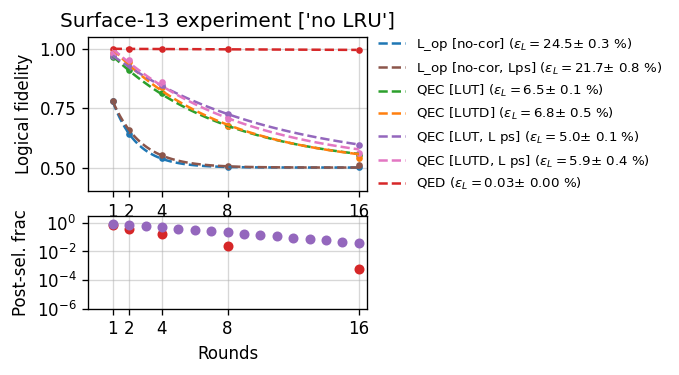

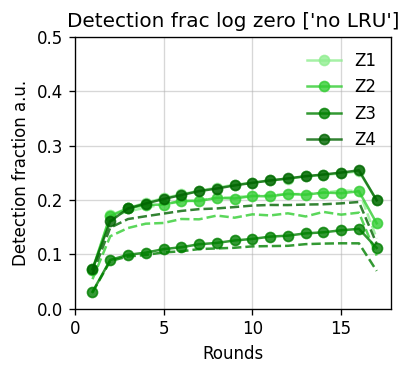

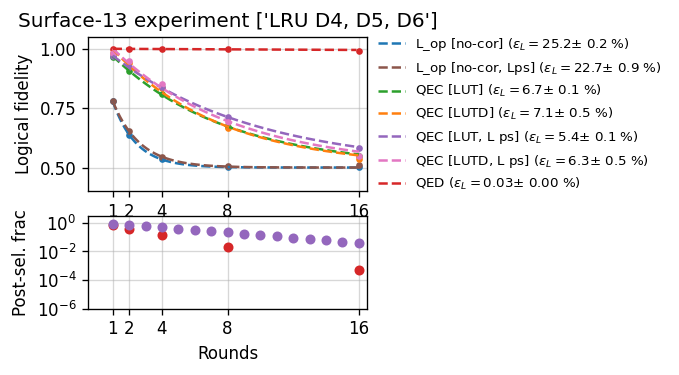

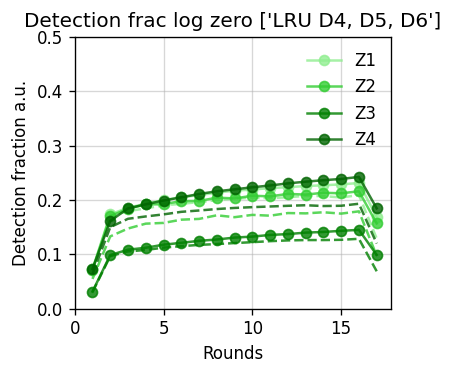

In [12]:
import os
L0_OP_L =  { f'{k}' : np.zeros(len(Rounds)) for k in range(n_kernels) }
L0_OP_PS_L =  { f'{k}' : np.zeros(len(Rounds)) for k in range(n_kernels) }
L0_QEC_L = { f'{k}' : np.zeros(len(Rounds)) for k in range(n_kernels) }
L0_QEC_D_L = { f'{k}' : np.zeros(len(Rounds)) for k in range(n_kernels) }
L0_QEC_D_F_L = { f'{k}' : np.zeros(len(Rounds)) for k in range(n_kernels) }
L0_QEC_PS_L = { f'{k}' : np.zeros(len(Rounds)) for k in range(n_kernels) }
PS_0_L =   { f'{k}' : np.zeros(len(Rounds)) for k in range(n_kernels) }
L0_QED_L = { f'{k}' : np.zeros(len(Rounds)) for k in range(n_kernels) }
D_L = { qb :{k:np.zeros(Rounds[-1]+1) for k in range(n_kernels)} for qb in ancilla_qubits}
D_f_L = { qb :{k:np.zeros(Rounds[-1]+1) for k in range(n_kernels)} for qb in ancilla_qubits}
keys = [['no LRU'], ['LRU D4, D5, D6']]
for state in states:
    for k in range(n_kernels):
        L0_OP_L[f'{k}'] += LOG_OP[f'{state}'][k] 
        L0_OP_PS_L[f'{k}'] += LOG_OP_PS[f'{state}'][k] 
        L0_QEC_L[f'{k}'] += LOG_OP_QEC[f'{state}'][k]
        L0_QEC_D_L[f'{k}'] += LOG_OP_QEC_D[f'{state}'][k]
        L0_QEC_D_F_L[f'{k}'] += LOG_OP_QEC_D_F[f'{state}'][k]
        L0_QEC_PS_L[f'{k}'] += LOG_OP_QEC_ps[f'{state}'][k]
        L0_QED_L[f'{k}'] += LOG_OP_QED[f'{state}'][k]
        PS_0_L[f'{k}'] += PS_FRACTION[f'{state}'][k]
        for qb in ancilla_qubits:
            D_L[qb][k] += defects[qb][f'{state}'][k]
            D_f_L[qb][k] += defects_f[qb][f'{state}'][k]
for k in range(n_kernels):       
    L0_OP_L[f'{k}'] = np.array(L0_OP_L[f'{k}'])*(1/len(LOG_OP.keys()))
    L0_OP_PS_L[f'{k}'] = np.array(L0_OP_PS_L[f'{k}'])*(1/len(LOG_OP_QEC_ps.keys()))
    L0_QEC_L[f'{k}'] = np.array(L0_QEC_L[f'{k}'])*(1/len(LOG_OP_QEC.keys()))
    L0_QEC_D_L[f'{k}'] = np.array(L0_QEC_D_L[f'{k}'])*(1/len(LOG_OP_QEC_D.keys()))
    L0_QEC_D_F_L[f'{k}'] = np.array(L0_QEC_D_F_L[f'{k}'])*(1/len(LOG_OP_QEC_D_F.keys()))
    L0_QEC_PS_L[f'{k}'] = np.array(L0_QEC_PS_L[f'{k}'])*(1/len(LOG_OP_QEC_ps.keys()))
    L0_QED_L[f'{k}'] = np.array(L0_QED_L[f'{k}'])*(1/len(LOG_OP_QED.keys()))
    PS_0_L[f'{k}'] = np.array(PS_0_L[f'{k}'])*(1/len(PS_FRACTION.keys()))
    for qb in ancilla_qubits:
        D_L[qb][k] = np.array(D_L[qb][k])*(1/len(defects[qb].keys()))
        D_f_L[qb][k] = np.array(D_f_L[qb][k])*(1/len(defects_f[qb].keys()))
    ## fitting model
    from lmfit import Model
    def func(qec_round, err_rate=0.1, round_offset = 0):
        return 0.5 * (1 + (1 - 2*err_rate)**(qec_round-round_offset))
    log_decay_model = Model(func)
    # fitting 
    fit_L = log_decay_model.fit(L0_OP_L[f'{k}'], qec_round = Rounds)
    fit_L_PS = log_decay_model.fit(L0_OP_PS_L[f'{k}'], qec_round = Rounds)
    fit_L_QEC = log_decay_model.fit(L0_QEC_L[f'{k}'], qec_round = Rounds)
    fit_L_QEC_D = log_decay_model.fit(L0_QEC_D_L[f'{k}'], qec_round = Rounds)
    fit_L_QEC_D_F = log_decay_model.fit(L0_QEC_D_F_L[f'{k}'], qec_round = Rounds)
    fit_L_QEC_PS = log_decay_model.fit(L0_QEC_PS_L[f'{k}'], qec_round = Rounds)
    fit_L_QED = log_decay_model.fit(L0_QED_L[f'{k}'][:-1], qec_round = Rounds[:-1])
    fig, ax = plt.subplots(figsize=(3,3), dpi =120, nrows=2, ncols=1,
                           gridspec_kw={'height_ratios': [2,1.2]})
    ax[0].plot(np.array(Rounds),L0_OP_L[f'{k}'],'C0.')
    ax[0].plot(np.array(Rounds),L0_OP_PS_L[f'{k}'],'C5.')
    ax[0].plot(np.array(Rounds),L0_QED_L[f'{k}'],'C3.')
    ax[0].plot(np.array(Rounds),L0_QEC_L[f'{k}'],'C2.')
    ax[0].plot(np.array(Rounds),L0_QEC_D_L[f'{k}'],'C1.')
    ax[0].plot(np.array(Rounds),L0_QEC_PS_L[f'{k}'],'C4.')
    ax[0].plot(np.array(Rounds),L0_QEC_D_F_L[f'{k}'],'C6.')
    cycles_cont = np.linspace(1, Rounds[-1], 101)
    L_error = fit_L.params["err_rate"].value
    L_stdr = fit_L.params["err_rate"].stderr
    L_error_PS = fit_L_PS.params["err_rate"].value
    L_stdr_PS = fit_L_PS.params["err_rate"].stderr
    QEC_error = fit_L_QEC.params["err_rate"].value
    QEC_stdr = fit_L_QEC.params["err_rate"].stderr
    QEC_error_D = fit_L_QEC_D.params["err_rate"].value
    QEC_stdr_D = fit_L_QEC_D.params["err_rate"].stderr
    QEC_error_D_F = fit_L_QEC_D_F.params["err_rate"].value
    QEC_stdr_D_F = fit_L_QEC_D_F.params["err_rate"].stderr
    QEC_error_PS = fit_L_QEC_PS.params["err_rate"].value
    QEC_stdr_PS = fit_L_QEC_PS.params["err_rate"].stderr
    QED_error = fit_L_QED.params["err_rate"].value
    QED_stdr = fit_L_QED.params["err_rate"].stderr
    ax[0].plot(cycles_cont, log_decay_model.eval(fit_L.params, qec_round=cycles_cont), 
            'C0--',label=f'L_op [no-cor] ($\epsilon_L={L_error*100:.1f}$' + f'$\pm$ {L_stdr*100:.1f} %)')
    ax[0].plot(cycles_cont, log_decay_model.eval(fit_L_PS.params, qec_round=cycles_cont), 
            'C5--',label=f'L_op [no-cor, Lps] ($\epsilon_L={L_error_PS*100:.1f}$' + f'$\pm$ {L_stdr_PS*100:.1f} %)')
    ax[0].plot(cycles_cont, log_decay_model.eval(fit_L_QEC.params, qec_round=cycles_cont),
            'C2--',label=f'QEC [LUT] ($\epsilon_L={QEC_error*100:.1f}$' + f'$\pm$ {QEC_stdr*100:.1f} %)')
    ax[0].plot(cycles_cont, log_decay_model.eval(fit_L_QEC_D.params, qec_round=cycles_cont),
            'C1--',label=f'QEC [LUTD] ($\epsilon_L={QEC_error_D*100:.1f}$' + f'$\pm$ {QEC_stdr_D*100:.1f} %)')
    ax[0].plot(cycles_cont, log_decay_model.eval(fit_L_QEC_PS.params, qec_round=cycles_cont),
            'C4--',label=f'QEC [LUT, L ps] ($\epsilon_L={QEC_error_PS*100:.1f}$' + f'$\pm$ {QEC_stdr_PS*100:.1f} %)')
    ax[0].plot(cycles_cont, log_decay_model.eval(fit_L_QEC_D_F.params, qec_round=cycles_cont),
            'C6--',label=f'QEC [LUTD, L ps] ($\epsilon_L={QEC_error_D_F*100:.1f}$' + f'$\pm$ {QEC_stdr_D_F*100:.1f} %)')
    ax[0].plot(cycles_cont[:-1], log_decay_model.eval(fit_L_QED.params, qec_round=cycles_cont[:-1]),
            'C3--',label=f'QED ($\epsilon_L={QED_error*100:.2f}$' + f'$\pm$ {QED_stdr*100:.2f} %)')
    ax[0].set_xticks(Rounds)
    ax[0].set_yticks([1,0.75,0.5])
    # ax[0].set_xlabel('Rounds')
    ax[0].set_ylabel('Logical fidelity')
    ax[0].set_ylim(bottom=0.4)
    ax[0].set_ylim(top=1.05)
    ax[0].set_xlim(xmin = -0.5, xmax=Rounds[-1]+0.5)
    ax[0].grid(alpha=0.5)
    ax[0].set_title(f'Surface-13 experiment {keys[k]}')
    ax[0].legend(loc='center right', bbox_to_anchor=(2.1, 0.5),fontsize=8,frameon=False )

    ax[1].grid(alpha=0.5)
    ax[1].plot(Rounds, PS_0_L[f'{k}'], 'C3o', markersize=5)
    ax[1].plot(range(1,Rounds[-1]+1), Leakage_ps, 'C4o', markersize=5)
    ax[1].set_yscale('log')
    ax[1].set_yticks([1e0, 1e-2, 1e-4, 1e-6])
    ax[1].set_ylim(top=3, bottom=1e-6)
    ax[1].set_ylabel('Post-sel. frac')
    ax[1].set_xlabel('Rounds')
    ax[1].set_xticks(Rounds)
    ax[1].set_xlim(xmin = -0.5, xmax=Rounds[-1]+0.5)
    # ax[1].set_xlim(xmin = -0.5, xmax=Rounds[-1]+0.5)
    fig.patch.set_visible(False)
    fn = os.path.join(figdir, f"logical_performance_{k}.png")
    fig.savefig(fn, dpi=300, bbox_inches='tight', format='png')
    # plot defect rate
    colors = ['lightgreen', 'limegreen','green','darkgreen'] 
    # colors = ['deepskyblue', 'dodgerblue','royalblue','blue'] 
    fig, ax = plt.subplots(dpi=120, figsize = (3.4,3))
    Cycles = np.arange(1,Rounds[-1]+2)
    for i, anc in enumerate(ancilla_qubits):
        ax.plot(Cycles, D_L[anc][k],
                label =anc,marker='o',color = colors[i],alpha=0.8)
        ax.plot(Cycles, D_f_L[anc][k],'--',color = colors[i],alpha=0.8)
    ax.set_ylabel('Detection fraction a.u.')
    ax.set_ylim(ymax=0.5,ymin=0)
    ax.set_xticks([0, 5, 10, 15])
    ax.set_xlabel('Rounds')
    ax.legend(frameon=False)
    ax.set_title(f'Detection frac log zero {keys[k]}')
    ax.grid(alpha=0.5)
    fn = os.path.join(figdir, f"detection_rate_log_zero_flipped_{k}.png")
    fig.savefig(fn, dpi=300, bbox_inches='tight', format='png')

In [13]:
import numpy as np
import matplotlib.pyplot as plt
# Save data
np.save(f'./Logical_operator_V3_5.npy', L0_OP_L, allow_pickle=True)
np.save(f'./Logical_operator_PS_V3_5.npy', L0_OP_PS_L, allow_pickle=True)
np.save(f'./Logical_operator_QED_V3_5.npy', L0_QED_L, allow_pickle=True)
np.save(f'./Logical_operator_QEC_V3_5.npy', L0_QEC_L, allow_pickle=True)
np.save(f'./Logical_operator_QEC_D_V3_5.npy', L0_QEC_D_L, allow_pickle=True)
np.save(f'./Logical_operator_QEC_PS_V3_5.npy', L0_QEC_PS_L, allow_pickle=True)
np.save(f'./Logical_operator_QEC_D_PS_V3_5.npy', L0_QEC_D_F_L, allow_pickle=True)
np.save(f'./Logical_operator_PS_frac_V3_5.npy', PS_0_L, allow_pickle=True)
np.save(f'./Logical_operator_defect_V3_5.npy', D_L, allow_pickle=True)
np.save(f'./Logical_operator_defect_PS_V3_5.npy', D_f_L, allow_pickle=True)
np.save(f'./Logical_operator_L_PS_frac_V3_5.npy', Leakage_ps, allow_pickle=True)

In [15]:
defect = np.load(f'./Logical_operator_defect_V3_5.npy', allow_pickle=True).item()
# defect_f = np.load(f'./Logical_operator_defect_PS_V4.npy', allow_pickle=True).item()

Text(4.5, 0.03, 'dashed curves are LRU')

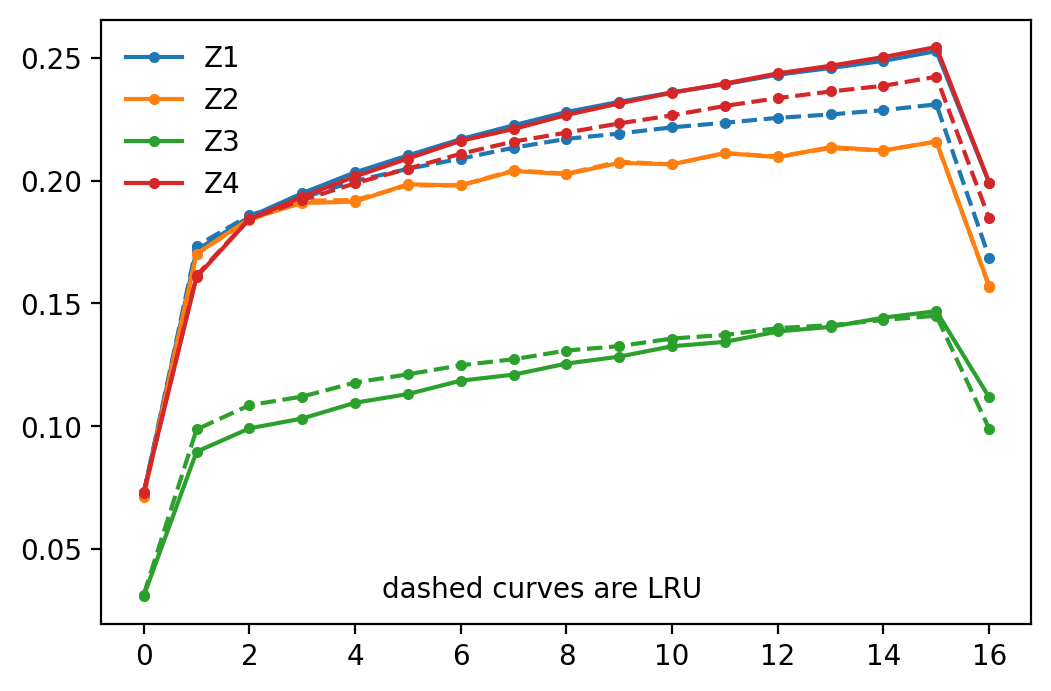

In [16]:
plt.figure(dpi=200)
ancilla_qubits = ['Z1', 'Z2', 'Z3', 'Z4']
colors = ['C0', 'C1', 'C2', 'C3']
for s, df in enumerate(defect.values()):
    plt.plot(df[0], '.-', color = colors[s], label=f'Z{s+1}')
    plt.plot(df[1], '.--',color = colors[s],)
plt.legend(frameon=False)
plt.text(4.5, 0.03, f'dashed curves are LRU')